In [43]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3

In [ ]:
src_path = os.path.abspath(os.path.join('..', '..', 'src'))
sys.path.append(src_path)

In [44]:
def scale_C_t(scale, alpha_t, scores, sigma_t, t, interval=50):
    alpha_t = min(1, max(0, alpha_t))
    Q = np.quantile(scores[t-interval:t], 1 - alpha_t)
    positve_v = (sigma_t) + scale *(abs(sigma_t) * Q)
    negative_v = (sigma_t) - scale *(abs(sigma_t) * Q)
    return negative_v, positve_v

def err_t(Y_t, C_t):
    if C_t[0] < Y_t < C_t[1]:
        return 0
    else:
        return 1

def scaled_ACI(coverage_target: float, timeseries_data: tuple, gamma: float, custom_interval: int) -> dict:
    xpred, y = timeseries_data
    alpha_t_list = [coverage_target]

    All_scores = (abs(y - xpred))/abs(xpred)

    err_t_list = []
    conformal_sets_list = []
    
    error_counter = 0
    for i in range(custom_interval+1, len(All_scores)):
        # Look back window
        look_back = min(max(3, custom_interval - 2*error_counter), i)
        scale = 1 + (custom_interval - look_back)/custom_interval

        Coverage_t = scale_C_t(scale, alpha_t_list[-1], All_scores, xpred[i], i, look_back)
        conformal_sets_list.append(Coverage_t)

        error_t = err_t(y[i], Coverage_t)
        err_t_list.append(error_t)

        #alpha_t = min(max(alpha_t_list[-1] + (gamma * (coverage_target - error_t)), 0), 1)
        #alpha_t_list.append(alpha_t)

        if error_t:
                error_counter+=1
        else:
            error_counter = max(-3, error_counter-1)

        

    # Calculating different averages
    realised_interval_coverage = 1 - pd.Series(err_t_list).rolling(custom_interval).mean().mean()
    average_prediction_interval = np.mean([abs(x[1] - x[0]) for x in conformal_sets_list])

    return {
        'model': 'scaled_ACI',
        'coverage_target': coverage_target,
        'gamma': gamma,
        'realised_interval_coverage': realised_interval_coverage,
        'alpha_t_list': alpha_t_list,
        'average_prediction_interval': average_prediction_interval,
        'conformal_sets': conformal_sets_list,
        'error_t_list': err_t_list, 
        'interval_size': custom_interval
    }

In [117]:
def scale_C_t(scale, alpha_t, scores, sigma_t, t, interval=50):
    alpha_t = min(1, max(0, alpha_t))
    Q = np.quantile(scores[t-interval:t], 1 - alpha_t)
    positve_v = (sigma_t) + scale *(abs(sigma_t) * Q)
    negative_v = (sigma_t) - scale *(abs(sigma_t) * Q)
    return negative_v, positve_v

def err_t(Y_t, C_t):
    if C_t[0] < Y_t < C_t[1]:
        return 0
    else:
        return 1

def parameter_lookback_upneg(coverage_target: float, timeseries_data: tuple, mu: int, sigma: float,  custom_interval: int) -> dict:
    xpred, y = timeseries_data
    alpha_t_list = [coverage_target]

    All_scores = (abs(y - xpred))/abs(xpred)

    err_t_list = []
    conformal_sets_list = []
    interval_list = []
    scale_list = []
    
    error_counter = 0
    for i in range(custom_interval+1, len(All_scores)):
        # Look back window
        look_back = min(max(round(mu), round(custom_interval - error_counter)), i)
        interval_list.append(look_back)

        scale = 1 + (custom_interval - look_back)/custom_interval
        scale_list.append(scale)

        Coverage_t = scale_C_t(scale, alpha_t_list[-1], All_scores, xpred[i], i, look_back)
        conformal_sets_list.append(Coverage_t)

        error_t = err_t(y[i], Coverage_t)
        err_t_list.append(error_t)


        if error_t:
                error_counter+=sigma
        else:
            error_counter = max(0, error_counter- 0.33*sigma)

        

    # Calculating different averages
    realised_interval_coverage = 1 - pd.Series(err_t_list).rolling(custom_interval).mean().mean()
    average_prediction_interval = np.mean([abs(x[1] - x[0]) for x in conformal_sets_list])

    return {
        'model': 'scaled_ACI_upneg',
        'coverage_target': coverage_target,
        'realised_interval_coverage': realised_interval_coverage,
        'alpha_t_list': alpha_t_list,
        'average_prediction_interval': average_prediction_interval,
        'conformal_sets': conformal_sets_list,
        'error_t_list': err_t_list, 
        'interval_list': interval_list,
        'scale_list': scale_list,
        'interval_size': custom_interval
    }

In [112]:
def parameter_lookback(coverage_target: float, timeseries_data: tuple, mu: int, sigma: float,  custom_interval: int) -> dict:
    xpred, y = timeseries_data
    alpha_t_list = [coverage_target]

    All_scores = (abs(y - xpred))/abs(xpred)

    err_t_list = []
    conformal_sets_list = []
    interval_list = []
    scale_list = []
    
    error_counter = 0
    for i in range(custom_interval+1, len(All_scores)):
        # Look back window
        look_back = min(max(round(mu), round(custom_interval - error_counter)), i)
        interval_list.append(look_back)

        scale = 1 + (custom_interval - look_back)/custom_interval
        scale_list.append(scale)

        Coverage_t = scale_C_t(scale, alpha_t_list[-1], All_scores, xpred[i], i, look_back)
        conformal_sets_list.append(Coverage_t)

        error_t = err_t(y[i], Coverage_t)
        err_t_list.append(error_t)


        if error_t:
                error_counter+=sigma
        else:
            error_counter = max(-mu, error_counter - sigma)

        

    # Calculating different averages
    realised_interval_coverage = 1 - pd.Series(err_t_list).rolling(custom_interval).mean().mean()
    average_prediction_interval = np.mean([abs(x[1] - x[0]) for x in conformal_sets_list])

    return {
        'model': 'scaled_ACI',
        'coverage_target': coverage_target,
        'realised_interval_coverage': realised_interval_coverage,
        'alpha_t_list': alpha_t_list,
        'average_prediction_interval': average_prediction_interval,
        'conformal_sets': conformal_sets_list,
        'error_t_list': err_t_list, 
        'interval_list': interval_list,
        'scale_list': scale_list,
        'interval_size': custom_interval
    }

In [107]:
# Plot the interval window

def plot_scale_interval(data):
    error_list = data['error_t_list']
    conformal_sets = data['conformal_sets']
    alpha_list = data['alpha_t_list']
    coverage = data['realised_interval_coverage']
    interval_size = data['interval_size']
    interval_list = data['interval_list']
    scale_list = data['scale_list']

    fig, axs = plt.subplots(3, 2, figsize=(15, 7))
    fig.suptitle('Adaptive Conformal Prediction for '+ data['model'])

    axs[0][0].plot(1 - pd.Series(error_list).rolling(interval_size).mean())
    axs[0][0].axhline(coverage, color='r', linestyle='--')
    axs[0][0].set_title('Realised Coverage')
    
    axs[0][1].plot([ele[0] for ele in conformal_sets], label='Lower')
    axs[0][1].plot([ele[1] for ele in conformal_sets], label='Upper')
    axs[0][1].set_title('Conformal sets')
    axs[0][1].legend()

    axs[1][0].plot([ele[1]-ele[0] for ele in conformal_sets], label='Distance')
    axs[1][0].axhline(np.mean([ele[1]-ele[0] for ele in conformal_sets]), color='r', linestyle='--')
    axs[1][0].legend()
    axs[1][0].set_title('Distance between upper and lower bounds')

    axs[1][1].plot(interval_list, label='lookback')
    axs[1][1].axhline(np.mean(interval_list), color='r', linestyle='--')
    axs[1][1].axhline(interval_size, color='g', linestyle='--')
    axs[1][1].legend()
    axs[1][1].set_title('Interval size')

    axs[2][0].plot(scale_list, label='scale')
    axs[2][0].axhline(np.mean(scale_list), color='r', linestyle='--')
    axs[2][0].legend()
    axs[2][0].set_title('Scale')

    plt.show()


In [3]:
import sys
sys.path.append('..')

from ConformalMethods import ACP_data
dataloader = ACP_data(100, 1200, dist_shifts=[(-1, 5), (5, 5), (5, 10)]) #, (20, 20), (30, 30)])
all_data = dataloader.generate()

0 0.9072988505747126


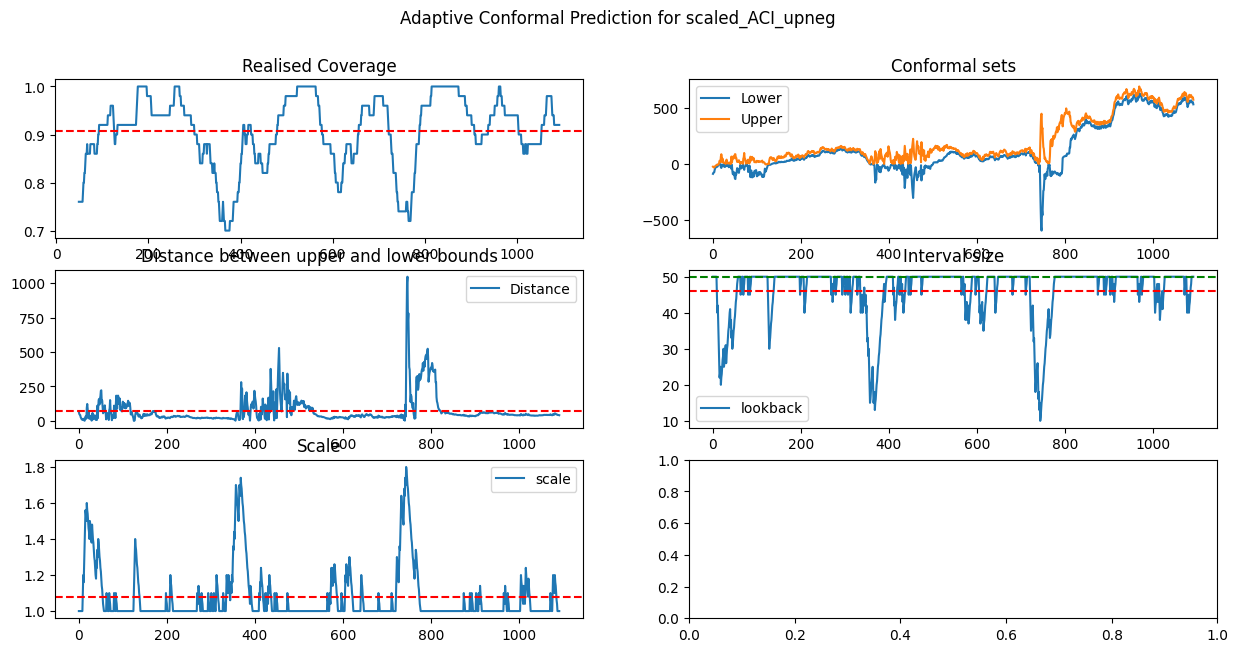

1 0.9016069581488325


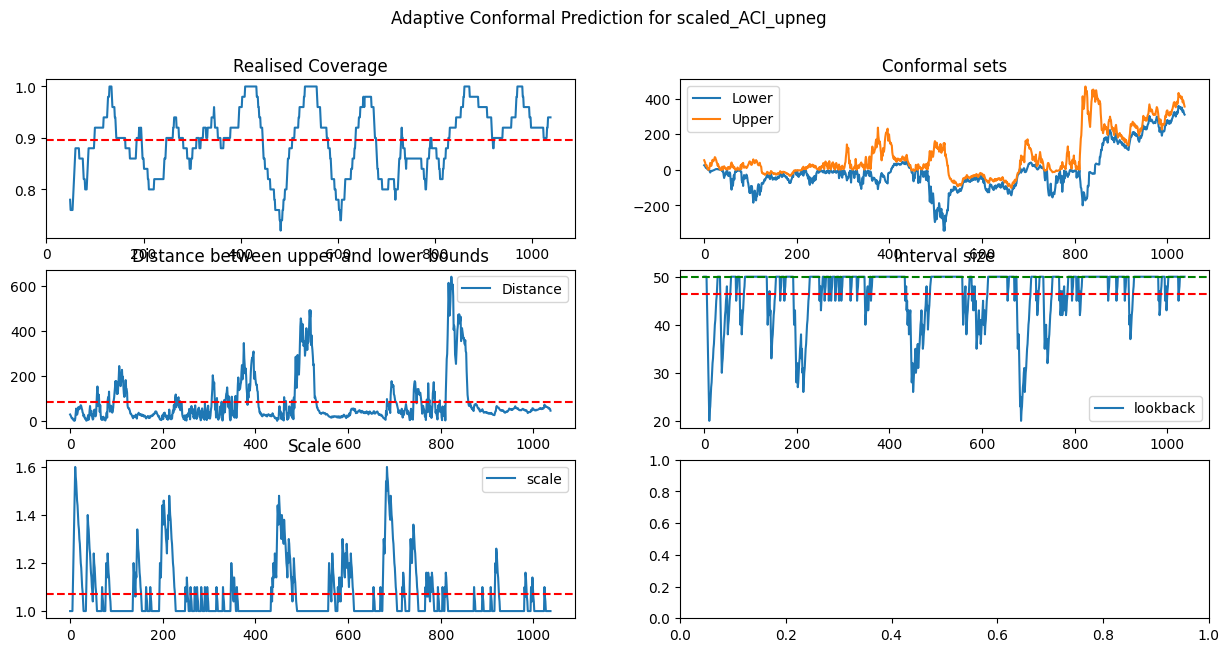

2 0.8960516975894177


KeyboardInterrupt: 

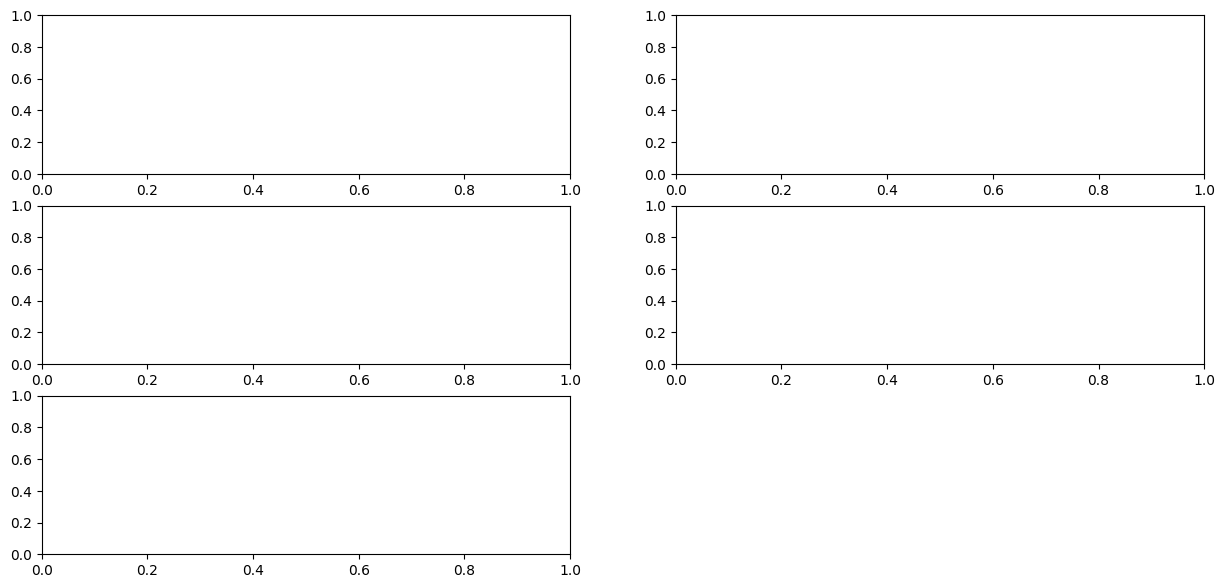

In [120]:
# Studying what is happening to the scale and the interval.

cov = []
for i, data in enumerate(all_data):
    plook = parameter_lookback_upneg(0.1, data, 5, 5, 50)
    cov.append(plook['realised_interval_coverage'])
    print(i, np.mean(cov))
    if i < 5:
        plot_scale_interval(plook)

Widths: my method 25.908443063228606 ACI 28.0031331972055 UpNeg 31.225137965048933
Coverage:my method 0.6958045977011494 ACI 0.6936973180076629 UpNeg 0.7579310344827586
Covearge Variance: my method 0.2153352156156327 ACI 0.2132609661917434 UpNeg 0.18829798543337833


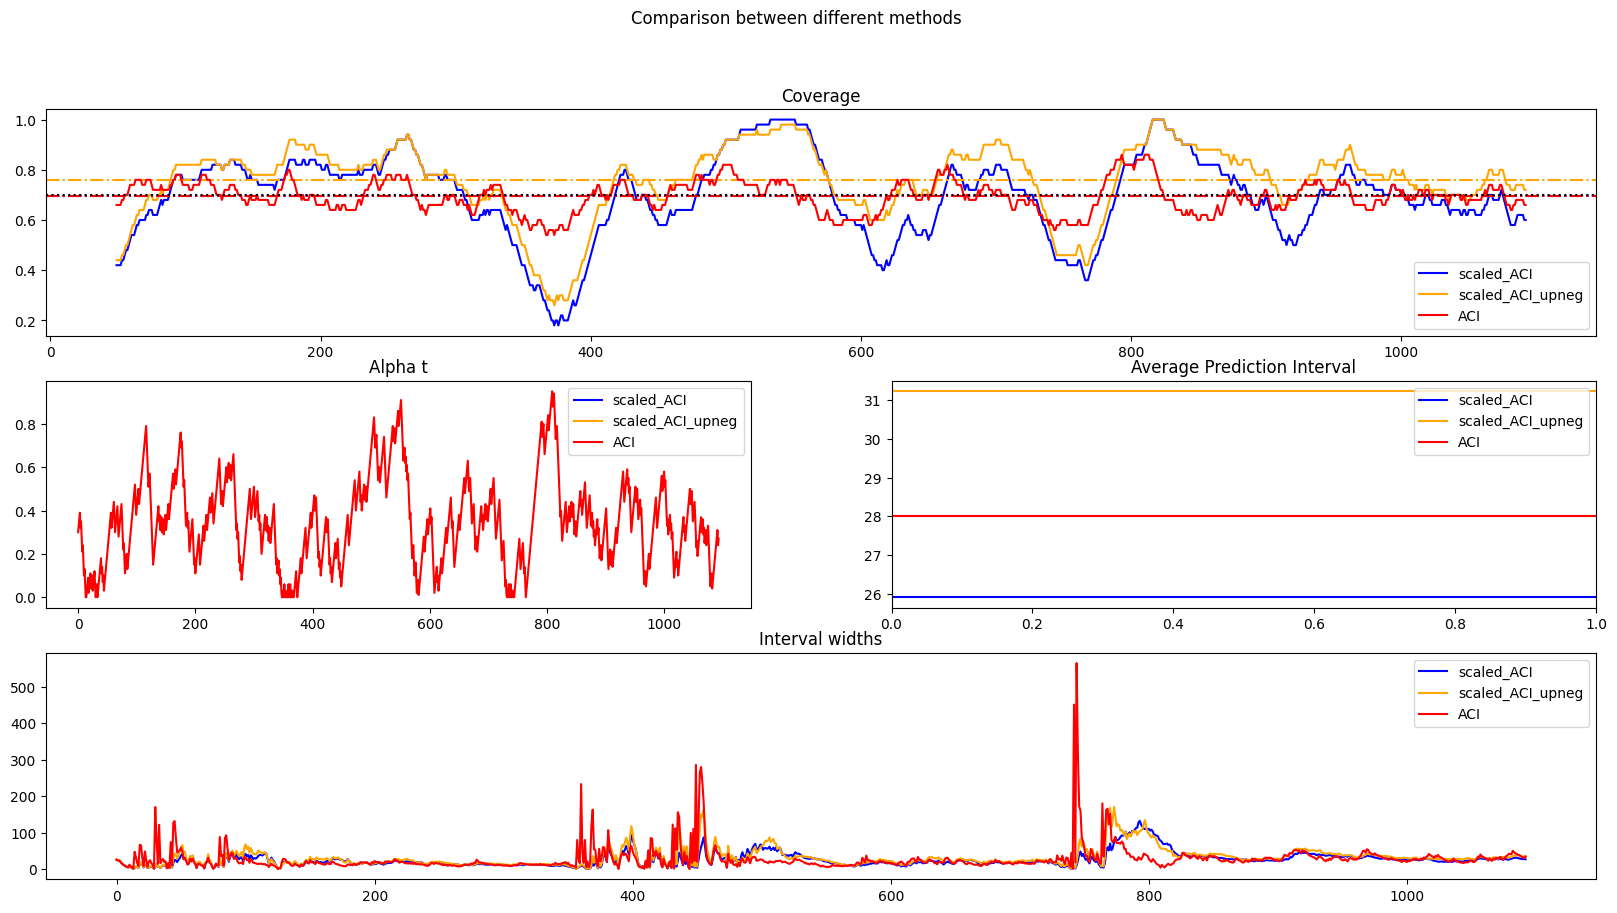

Widths: my method 28.83846626278985 ACI 39.188281713270044 UpNeg 34.499501882496155
Coverage:my method 0.6833421370709993 ACI 0.6948668592060558 UpNeg 0.7566904919633206
Covearge Variance: my method 0.2222222222222223 ACI 0.21175300061998575 UpNeg 0.1877406157535797


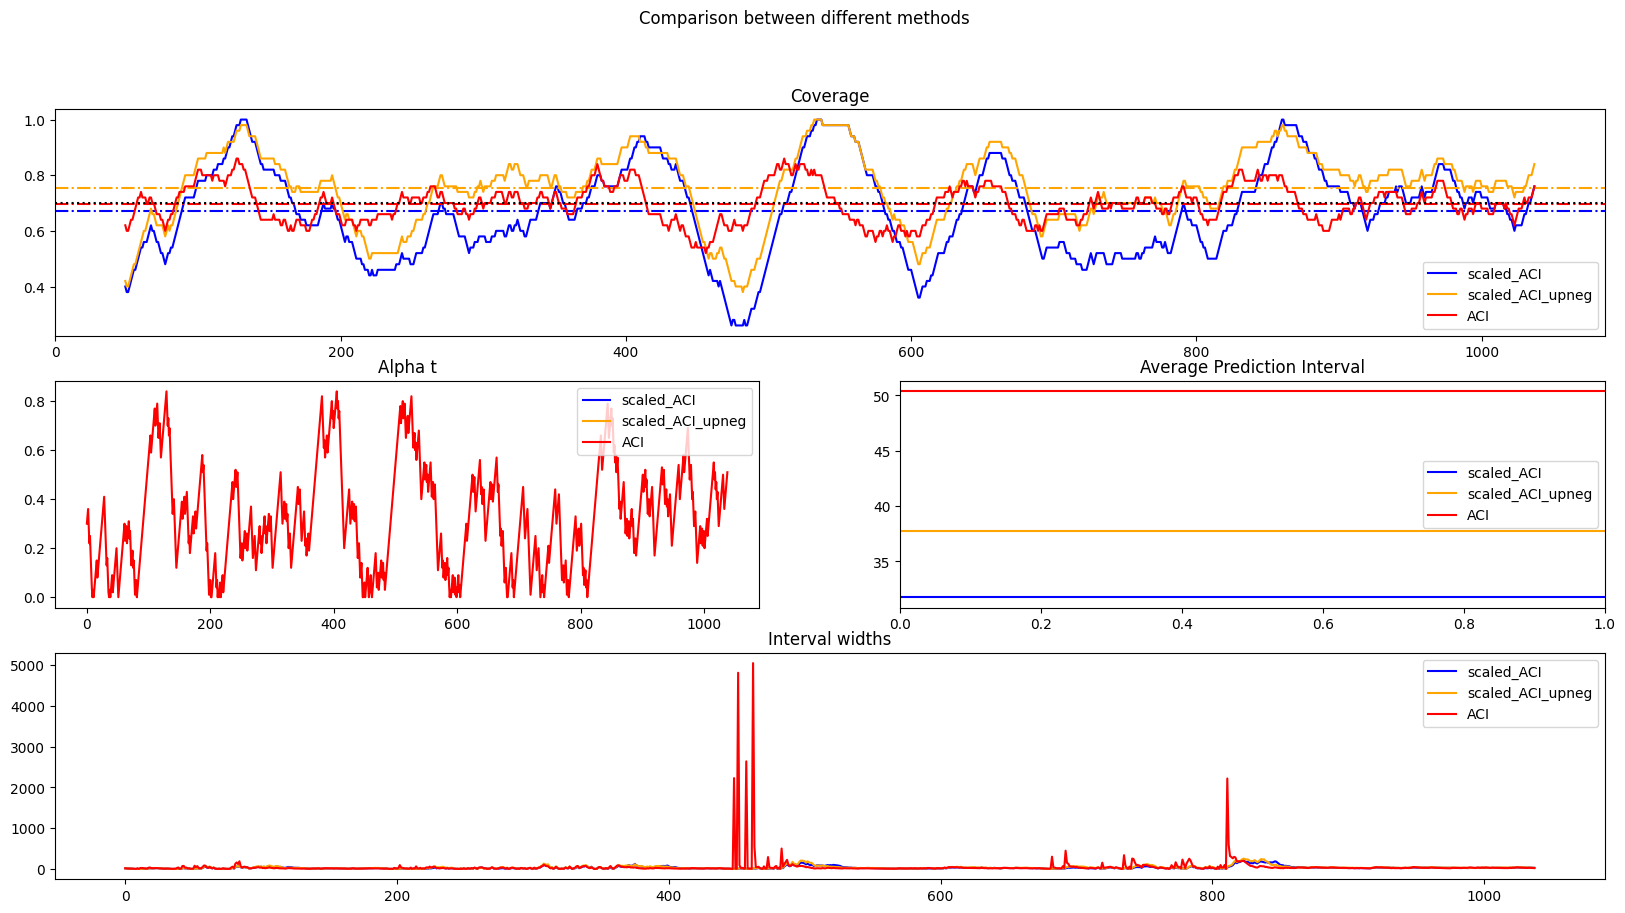

Widths: my method 30.849076437602168 ACI 41.53516042237805 UpNeg 37.545858231388706
Coverage:my method 0.6792555423610583 ACI 0.6934798669216843 UpNeg 0.7487662103284882
Covearge Variance: my method 0.22234567885959064 ACI 0.21528555396491716 UpNeg 0.19774783748102268


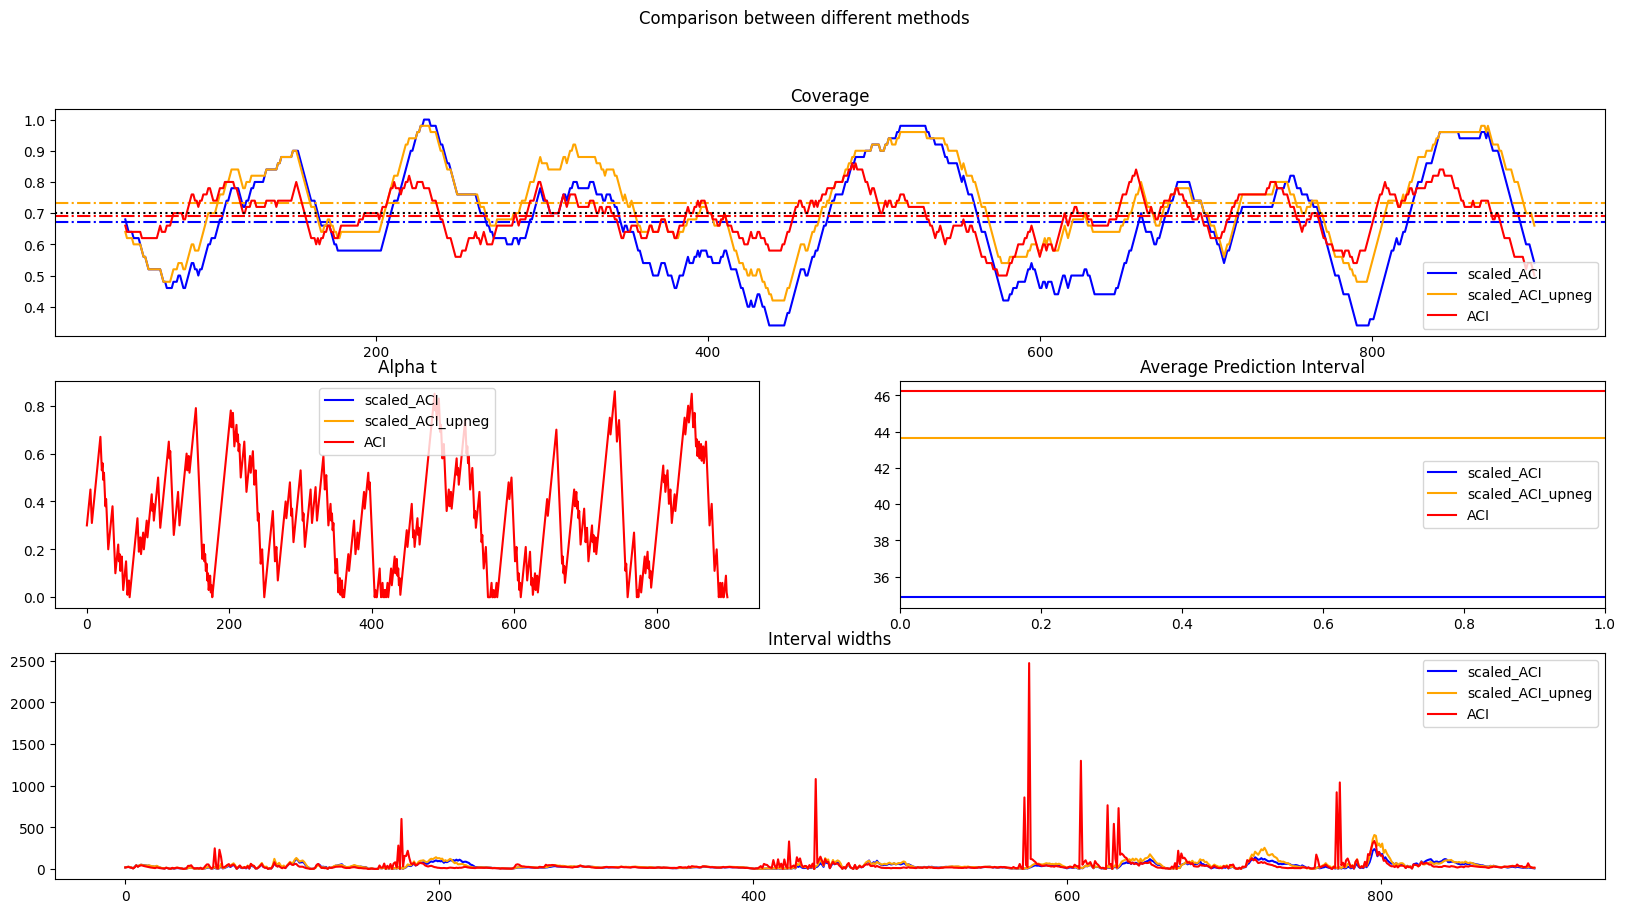

Widths: my method 29.188039728986997 ACI 37.940561352382126 UpNeg 35.533508706560674
Coverage:my method 0.6789556381289829 ACI 0.6923802064495854 UpNeg 0.7480127403029574
Covearge Variance: my method 0.21669375000000002 ACI 0.21294375 UpNeg 0.18624374999999996


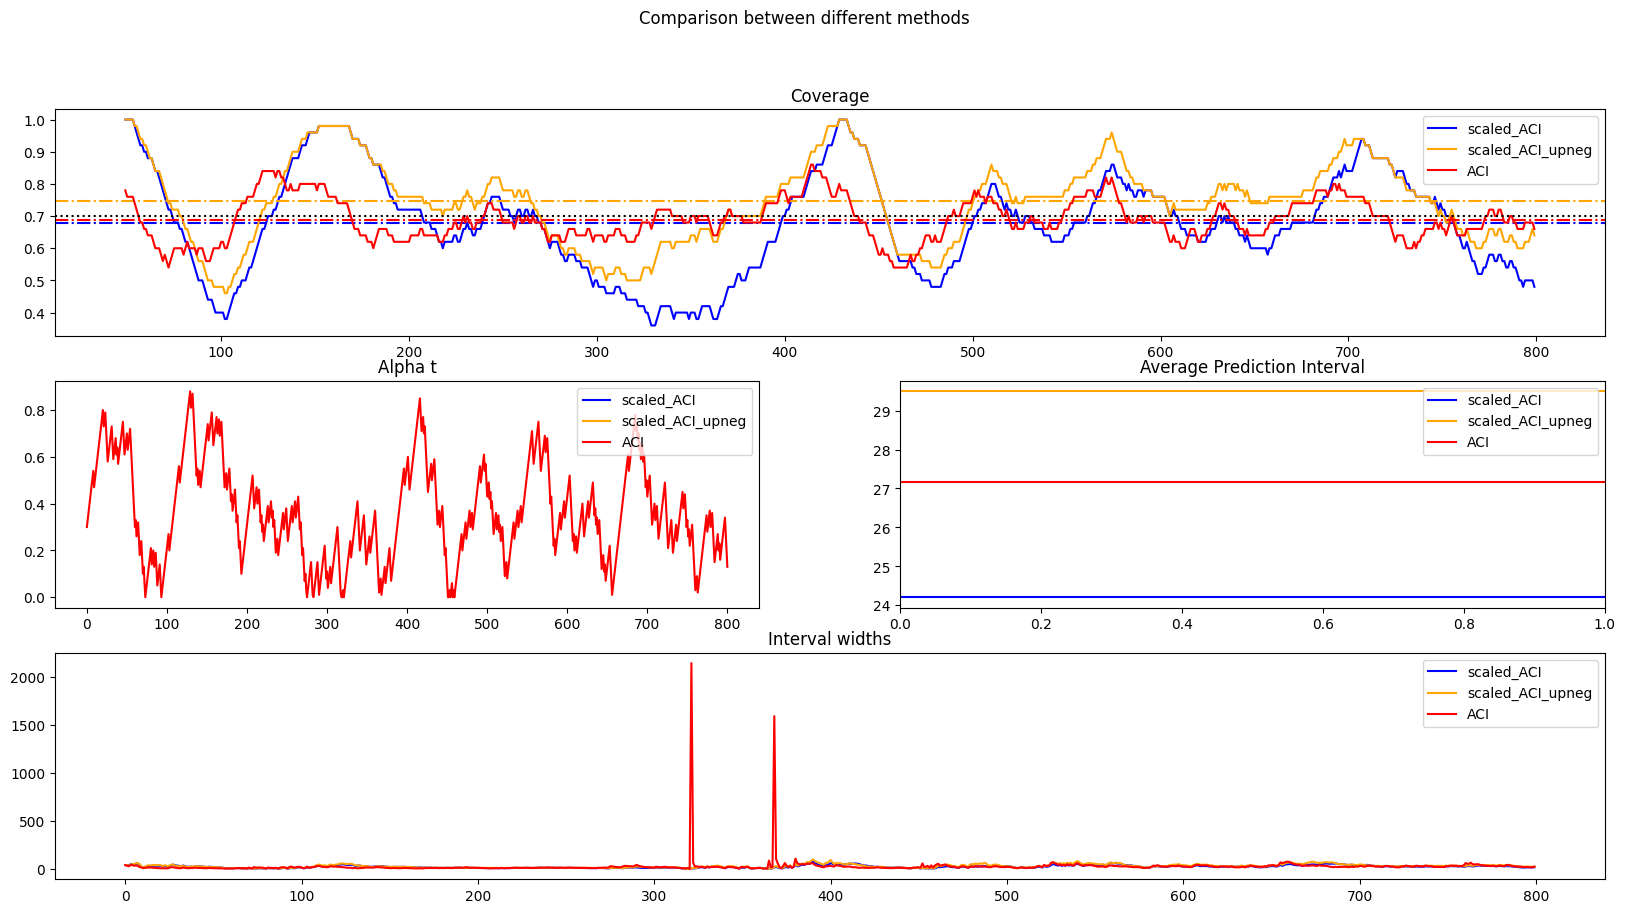

Widths: my method 27.447610230401324 ACI 34.4900625338242 UpNeg 33.13266572990627
Coverage:my method 0.6773194237979839 ACI 0.6932983848128476 UpNeg 0.751732735594967
Covearge Variance: my method 0.22161106828378396 ACI 0.21078386777049446 UpNeg 0.17931615664906225


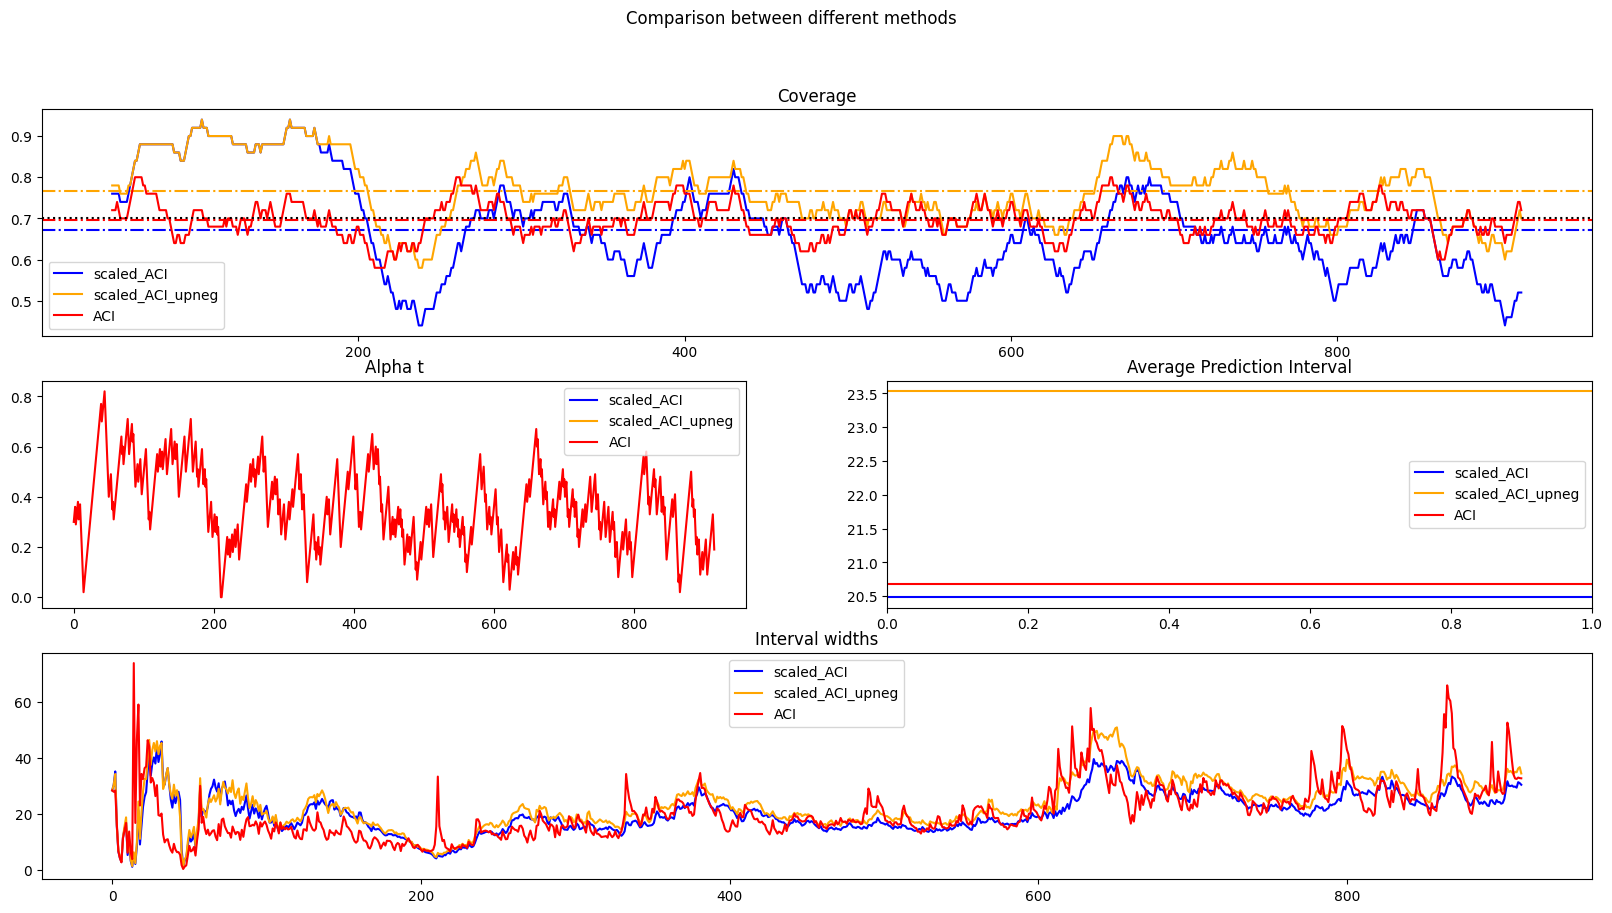

Widths: my method 28.414609101925453 ACI 44.350325182023006 UpNeg 35.04796195122857
Coverage:my method 0.6758955087666464 ACI 0.6924305350618819 UpNeg 0.7486465742682817
Covearge Variance: my method 0.22200241870491116 ACI 0.21351258905696818 UpNeg 0.19595407773963153


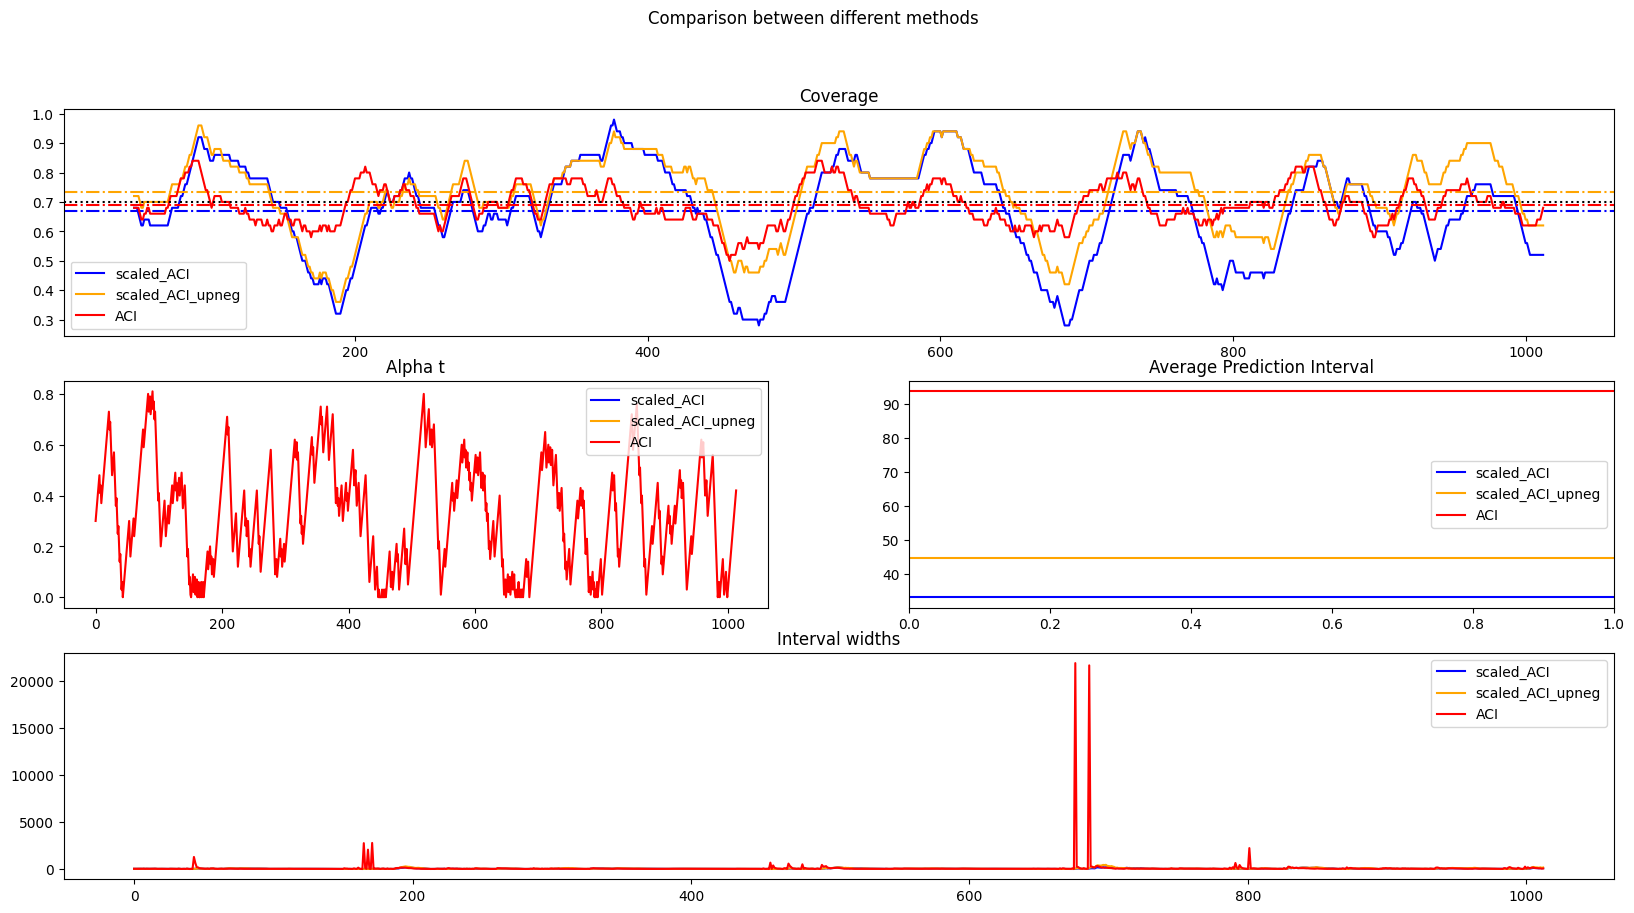

Widths: my method 28.026478237352876 ACI 41.86969910782971 UpNeg 34.39343109228336
Coverage:my method 0.6770982241041301 ACI 0.6928321636935947 UpNeg 0.7491221788659005
Covearge Variance: my method 0.21599528659203768 ACI 0.21036613079707095 UpNeg 0.1863479505092164


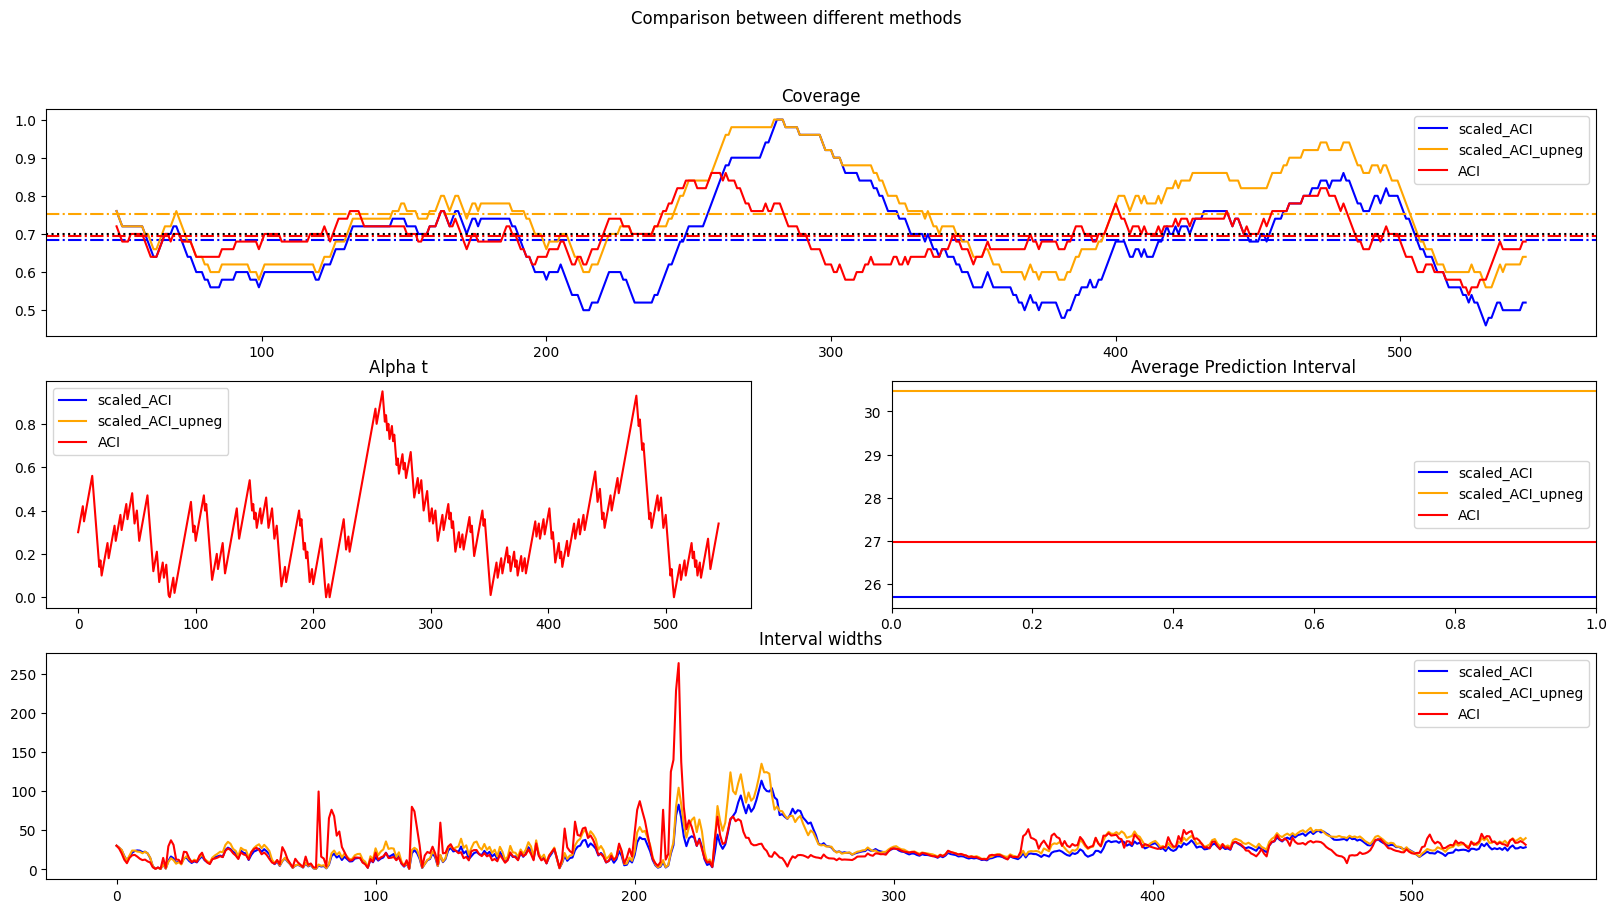

Widths: my method 27.122916371470843 ACI 39.4064019644308 UpNeg 33.1785326414414
Coverage:my method 0.6773262478152517 ACI 0.6936823458181023 UpNeg 0.7509560444386973
Covearge Variance: my method 0.21954492739351034 ACI 0.20954837411959198 UpNeg 0.18267648232793346


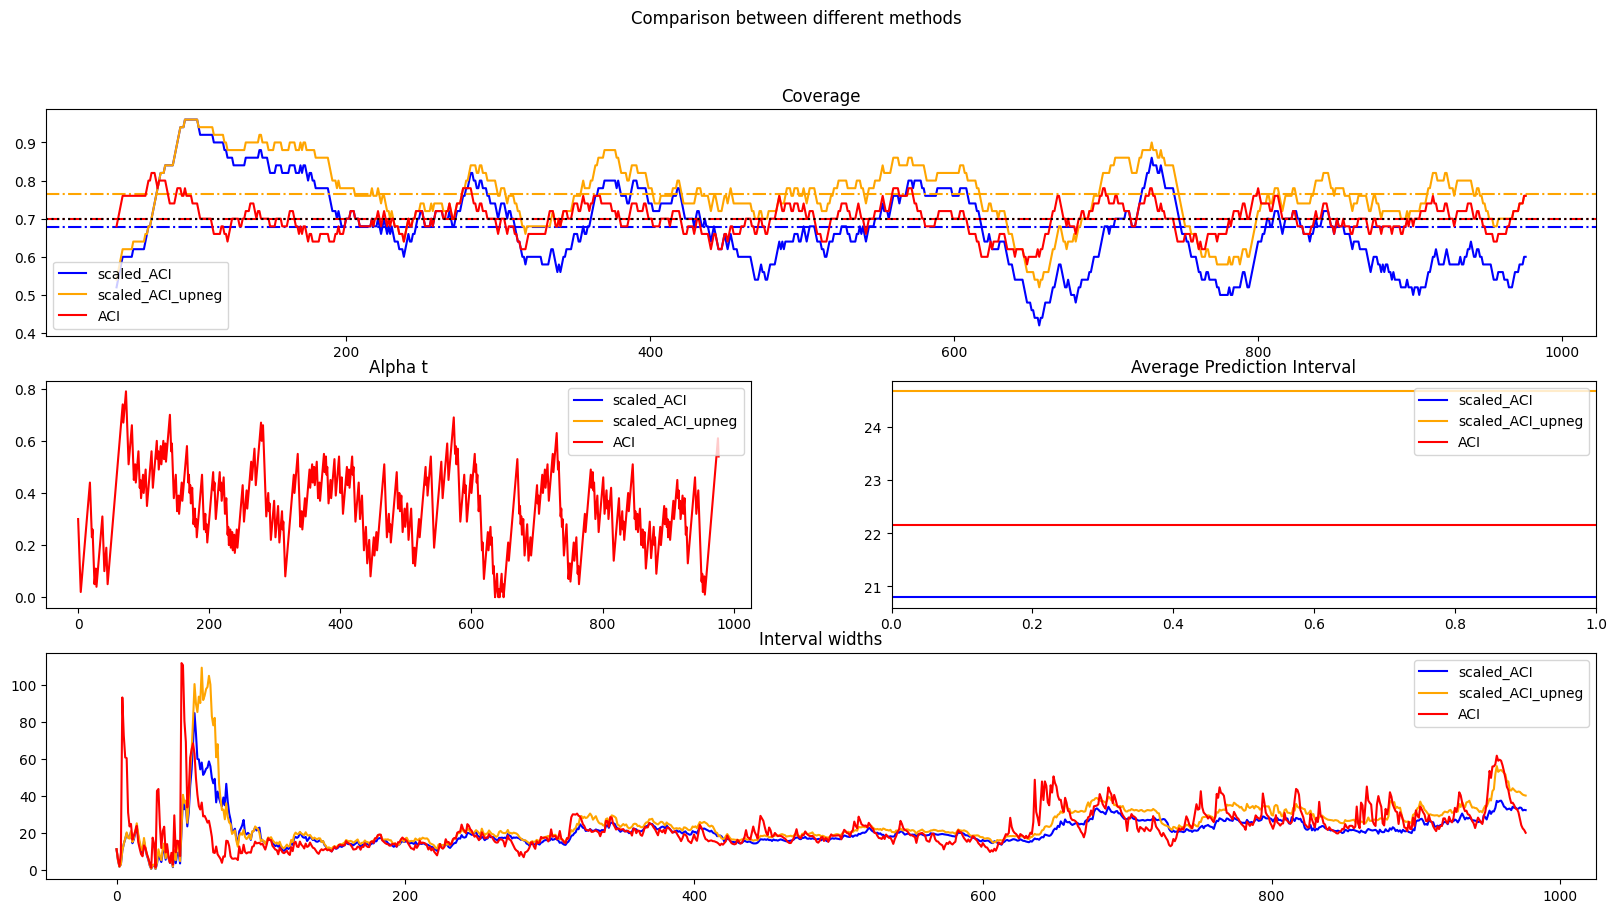

Widths: my method 27.33206575899164 ACI 38.5359698471956 UpNeg 33.54396769578649
Coverage:my method 0.6749775184229413 ACI 0.6932862298441783 UpNeg 0.7478292894196046
Covearge Variance: my method 0.221457029985347 ACI 0.21092482422931316 UpNeg 0.19623438087734704


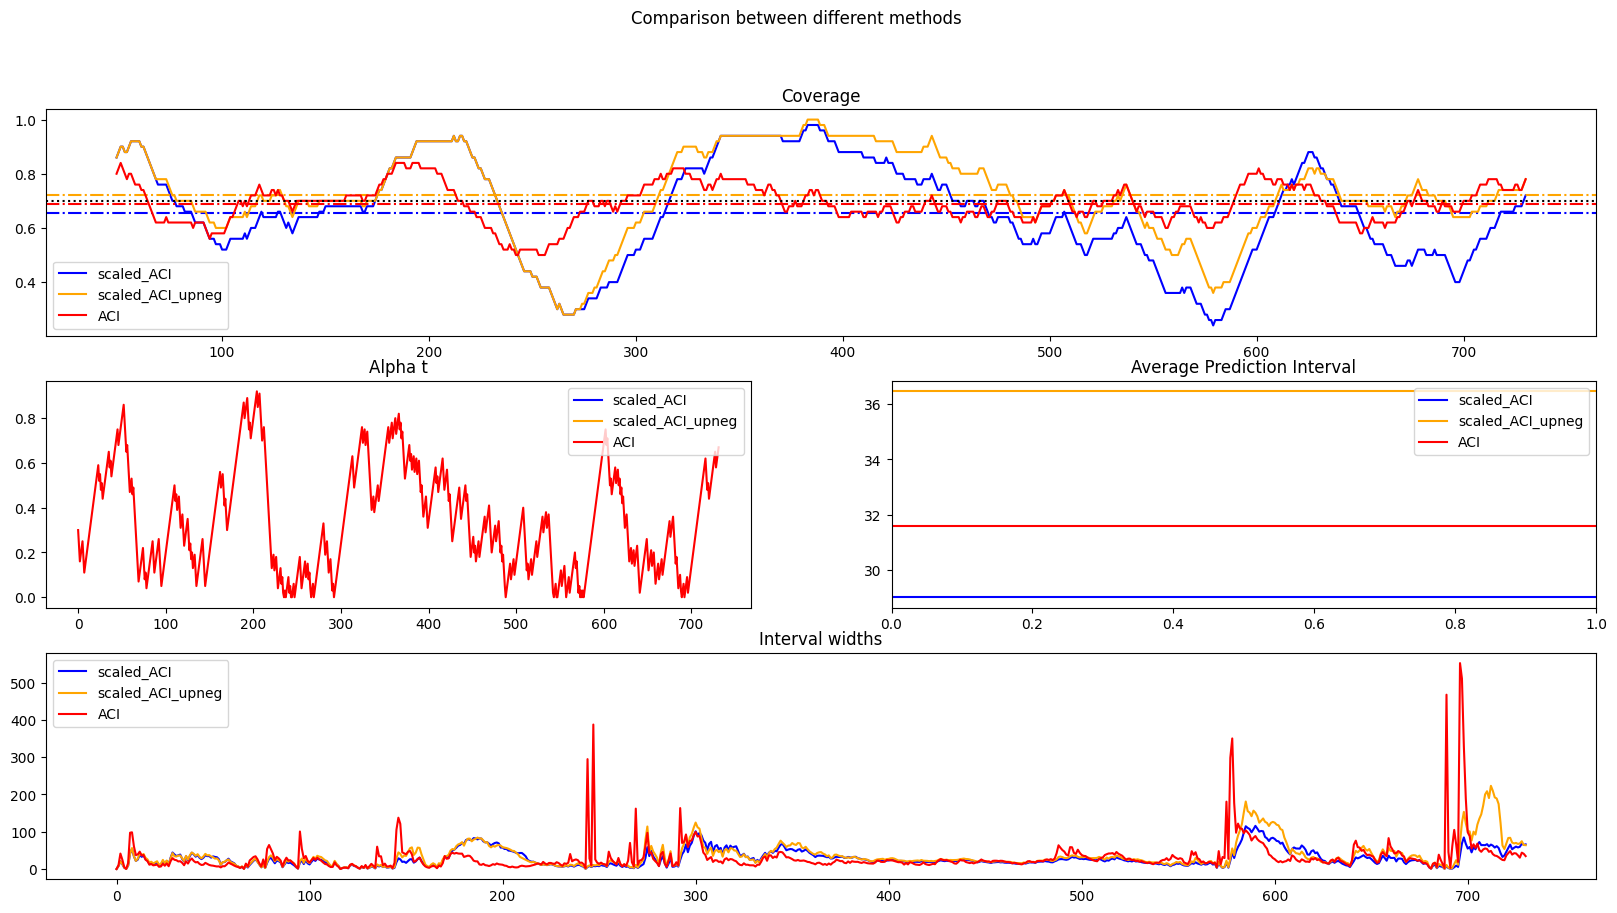

Widths: my method 27.067495323245094 ACI 37.58785102025711 UpNeg 33.107419224631386
Coverage:my method 0.6738661708740282 ACI 0.6928663725127121 UpNeg 0.7457046789034043
Covearge Variance: my method 0.2218555228531856 ACI 0.2142242685249308 UpNeg 0.19773361755540164


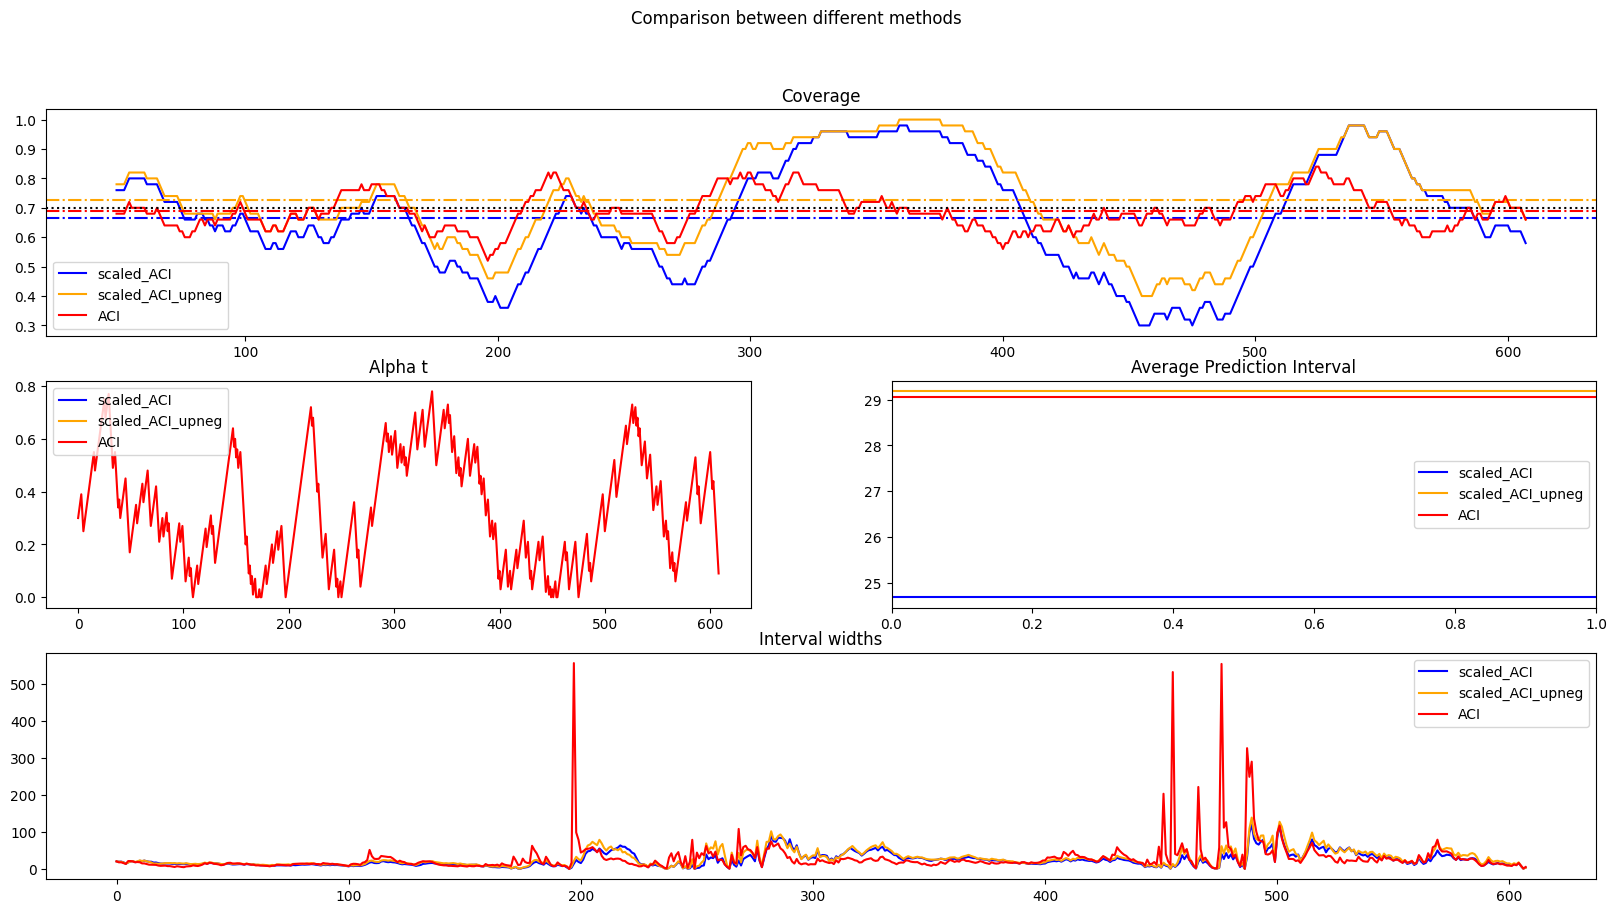

Widths: my method 27.597001889944526 ACI 36.96103986782143 UpNeg 34.106198403720214
Coverage:my method 0.6757793318378281 ACI 0.6930661216689703 UpNeg 0.7451398075619661
Covearge Variance: my method 0.20282651870354823 ACI 0.21214246227554723 UpNeg 0.18347802051555043
Widths: my method 26.90479689517275 ACI 35.701804689379834 UpNeg 33.14626132374688
Coverage:my method 0.6731837237373454 ACI 0.6933805970998751 UpNeg 0.745173250726896
Covearge Variance: my method 0.2257957039073839 ACI 0.2105460686808031 UpNeg 0.18577594295364985
Widths: my method 26.340518635708673 ACI 34.55652048236005 UpNeg 32.36642460814777
Coverage:my method 0.6718672672034773 ACI 0.6936835235502696 UpNeg 0.7464366772973848
Covearge Variance: my method 0.2232858497471901 ACI 0.20985927891253114 UpNeg 0.1781684637742038
Widths: my method 26.052551115488978 ACI 33.76999142930675 UpNeg 32.0822601621935
Coverage:my method 0.6714530606938273 ACI 0.6936310374358731 UpNeg 0.7452229463793177
Covearge Variance: my method 0.2

In [121]:
# This compares the method against the ACI method  

from ConformalMethods import ACP_plots
from ConformalMethods import AdaptiveCP
coverage_target = 0.3

ACP = AdaptiveCP(coverage_target)

records = [[], [], []]
coverage_records = [[], [], []]

for i, data in enumerate(all_data):
    plook = parameter_lookback(coverage_target, data, 5, 0.5, 50)
    plook_upneg = parameter_lookback_upneg(coverage_target, data, 5, 0.5, 50)
    non_adaptive = ACP.ACI(data, 0.1)


    records[0].append(plook['average_prediction_interval'])
    records[1].append(non_adaptive['average_prediction_interval'])
    records[2].append(plook_upneg['average_prediction_interval'])

    coverage_records[0].append(plook['realised_interval_coverage'])
    coverage_records[1].append(non_adaptive['realised_interval_coverage'])
    coverage_records[2].append(plook_upneg['realised_interval_coverage'])

    print('Widths: my method', np.mean(records[0]), 'ACI', np.mean(records[1]), 'UpNeg', np.mean(records[2]))
    print('Coverage:my method', np.mean(coverage_records[0]), 'ACI', np.mean(coverage_records[1]), 'UpNeg', np.mean(coverage_records[2]))
    print('Covearge Variance: my method', np.var(plook['error_t_list']) , 'ACI', np.var(np.array(non_adaptive['error_t_list'])),  'UpNeg', np.var(np.array(plook_upneg['error_t_list']) ))

    if i <10:
        ACP_plots.compare_many([plook, plook_upneg, non_adaptive], figsize=(20, 10))

Seems to be performing well however we are observing that it can seriously over cover, experiment with allowing window to get bigger. This acctualy does the opposite and makes it under cover, as i imagine the windows are smaller than they need to be. With a smaller min it is allowed it is performing better, I am wondering though to what extent I am optimising for the data and whether the method is acctualy robust, I feel like there may need to be some sort of adaptive method. Variance of the coverage is much higher meaning that it isnt realy learning the proper windows, but this makes sense as it is quite litteraly correcting its mistakes will need a fancier method if you want to avoid this, thinking that the widths should be somewhat learnt.

[(1.0, 0.5), (1.0, 2.0), (1.0, 3.5), (1.0, 5.0), (3.0, 0.5), (3.0, 2.0), (3.0, 3.5), (3.0, 5.0), (5.0, 0.5), (5.0, 2.0), (5.0, 3.5), (5.0, 5.0)]


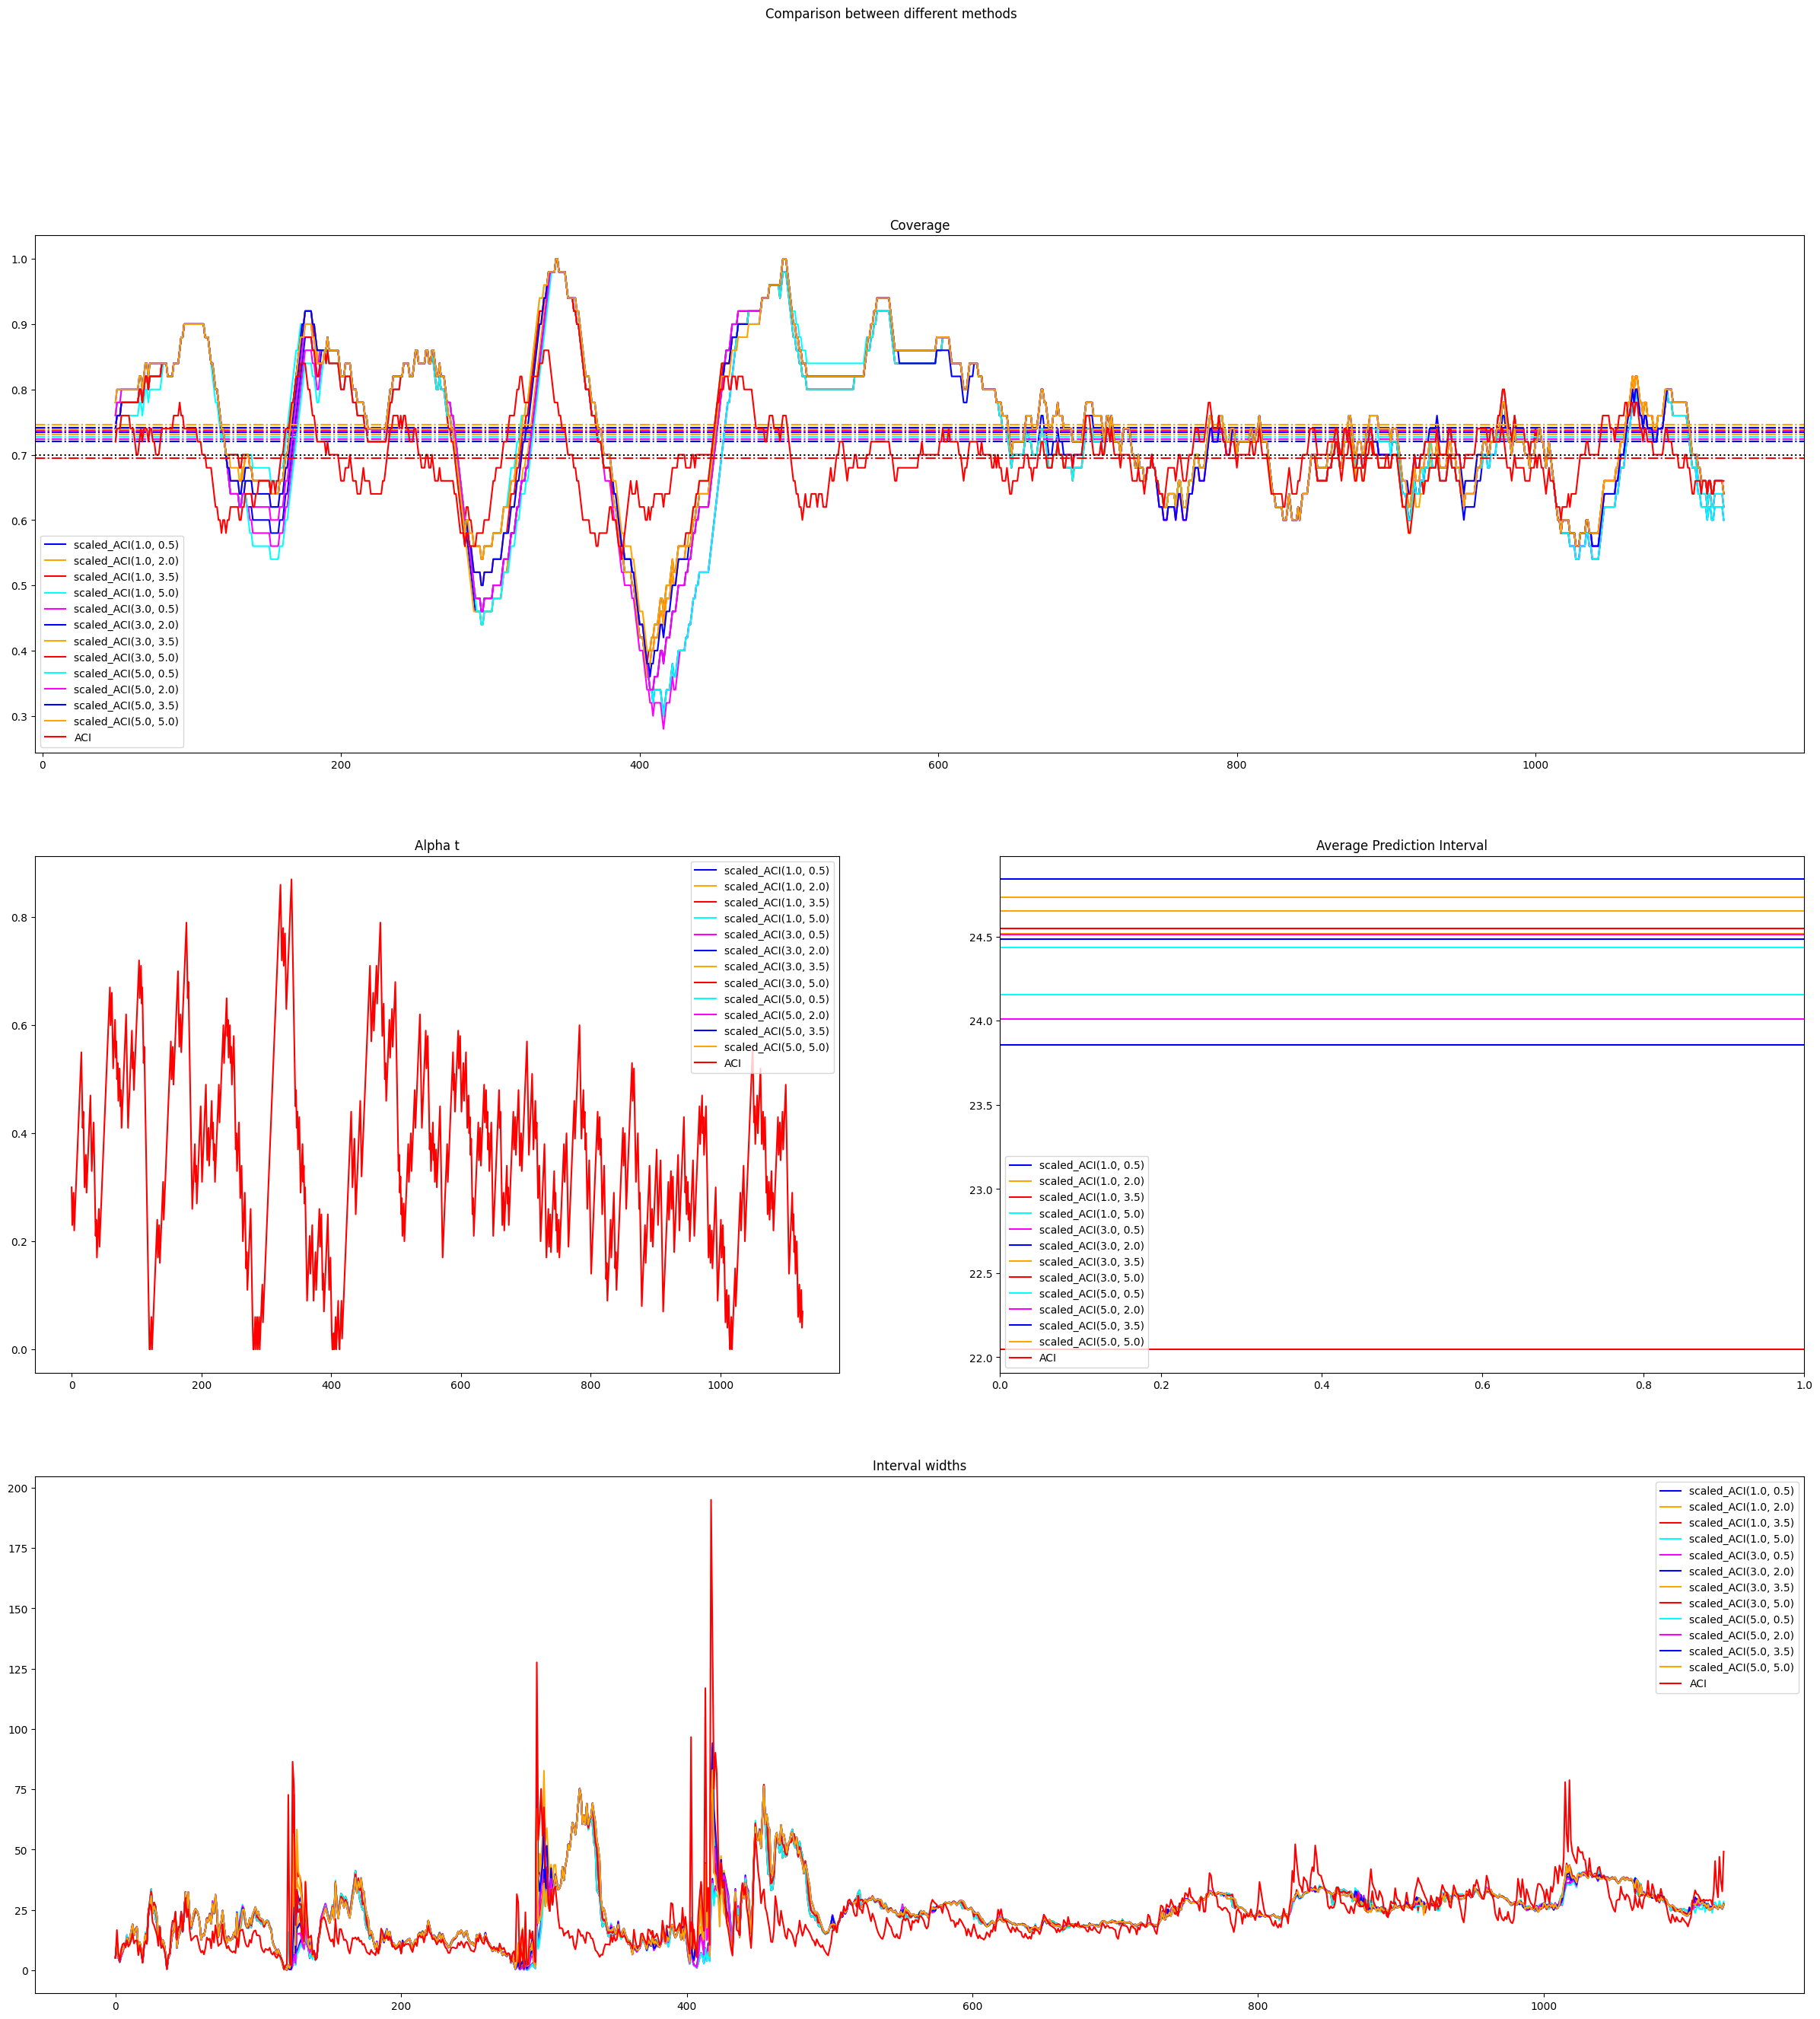

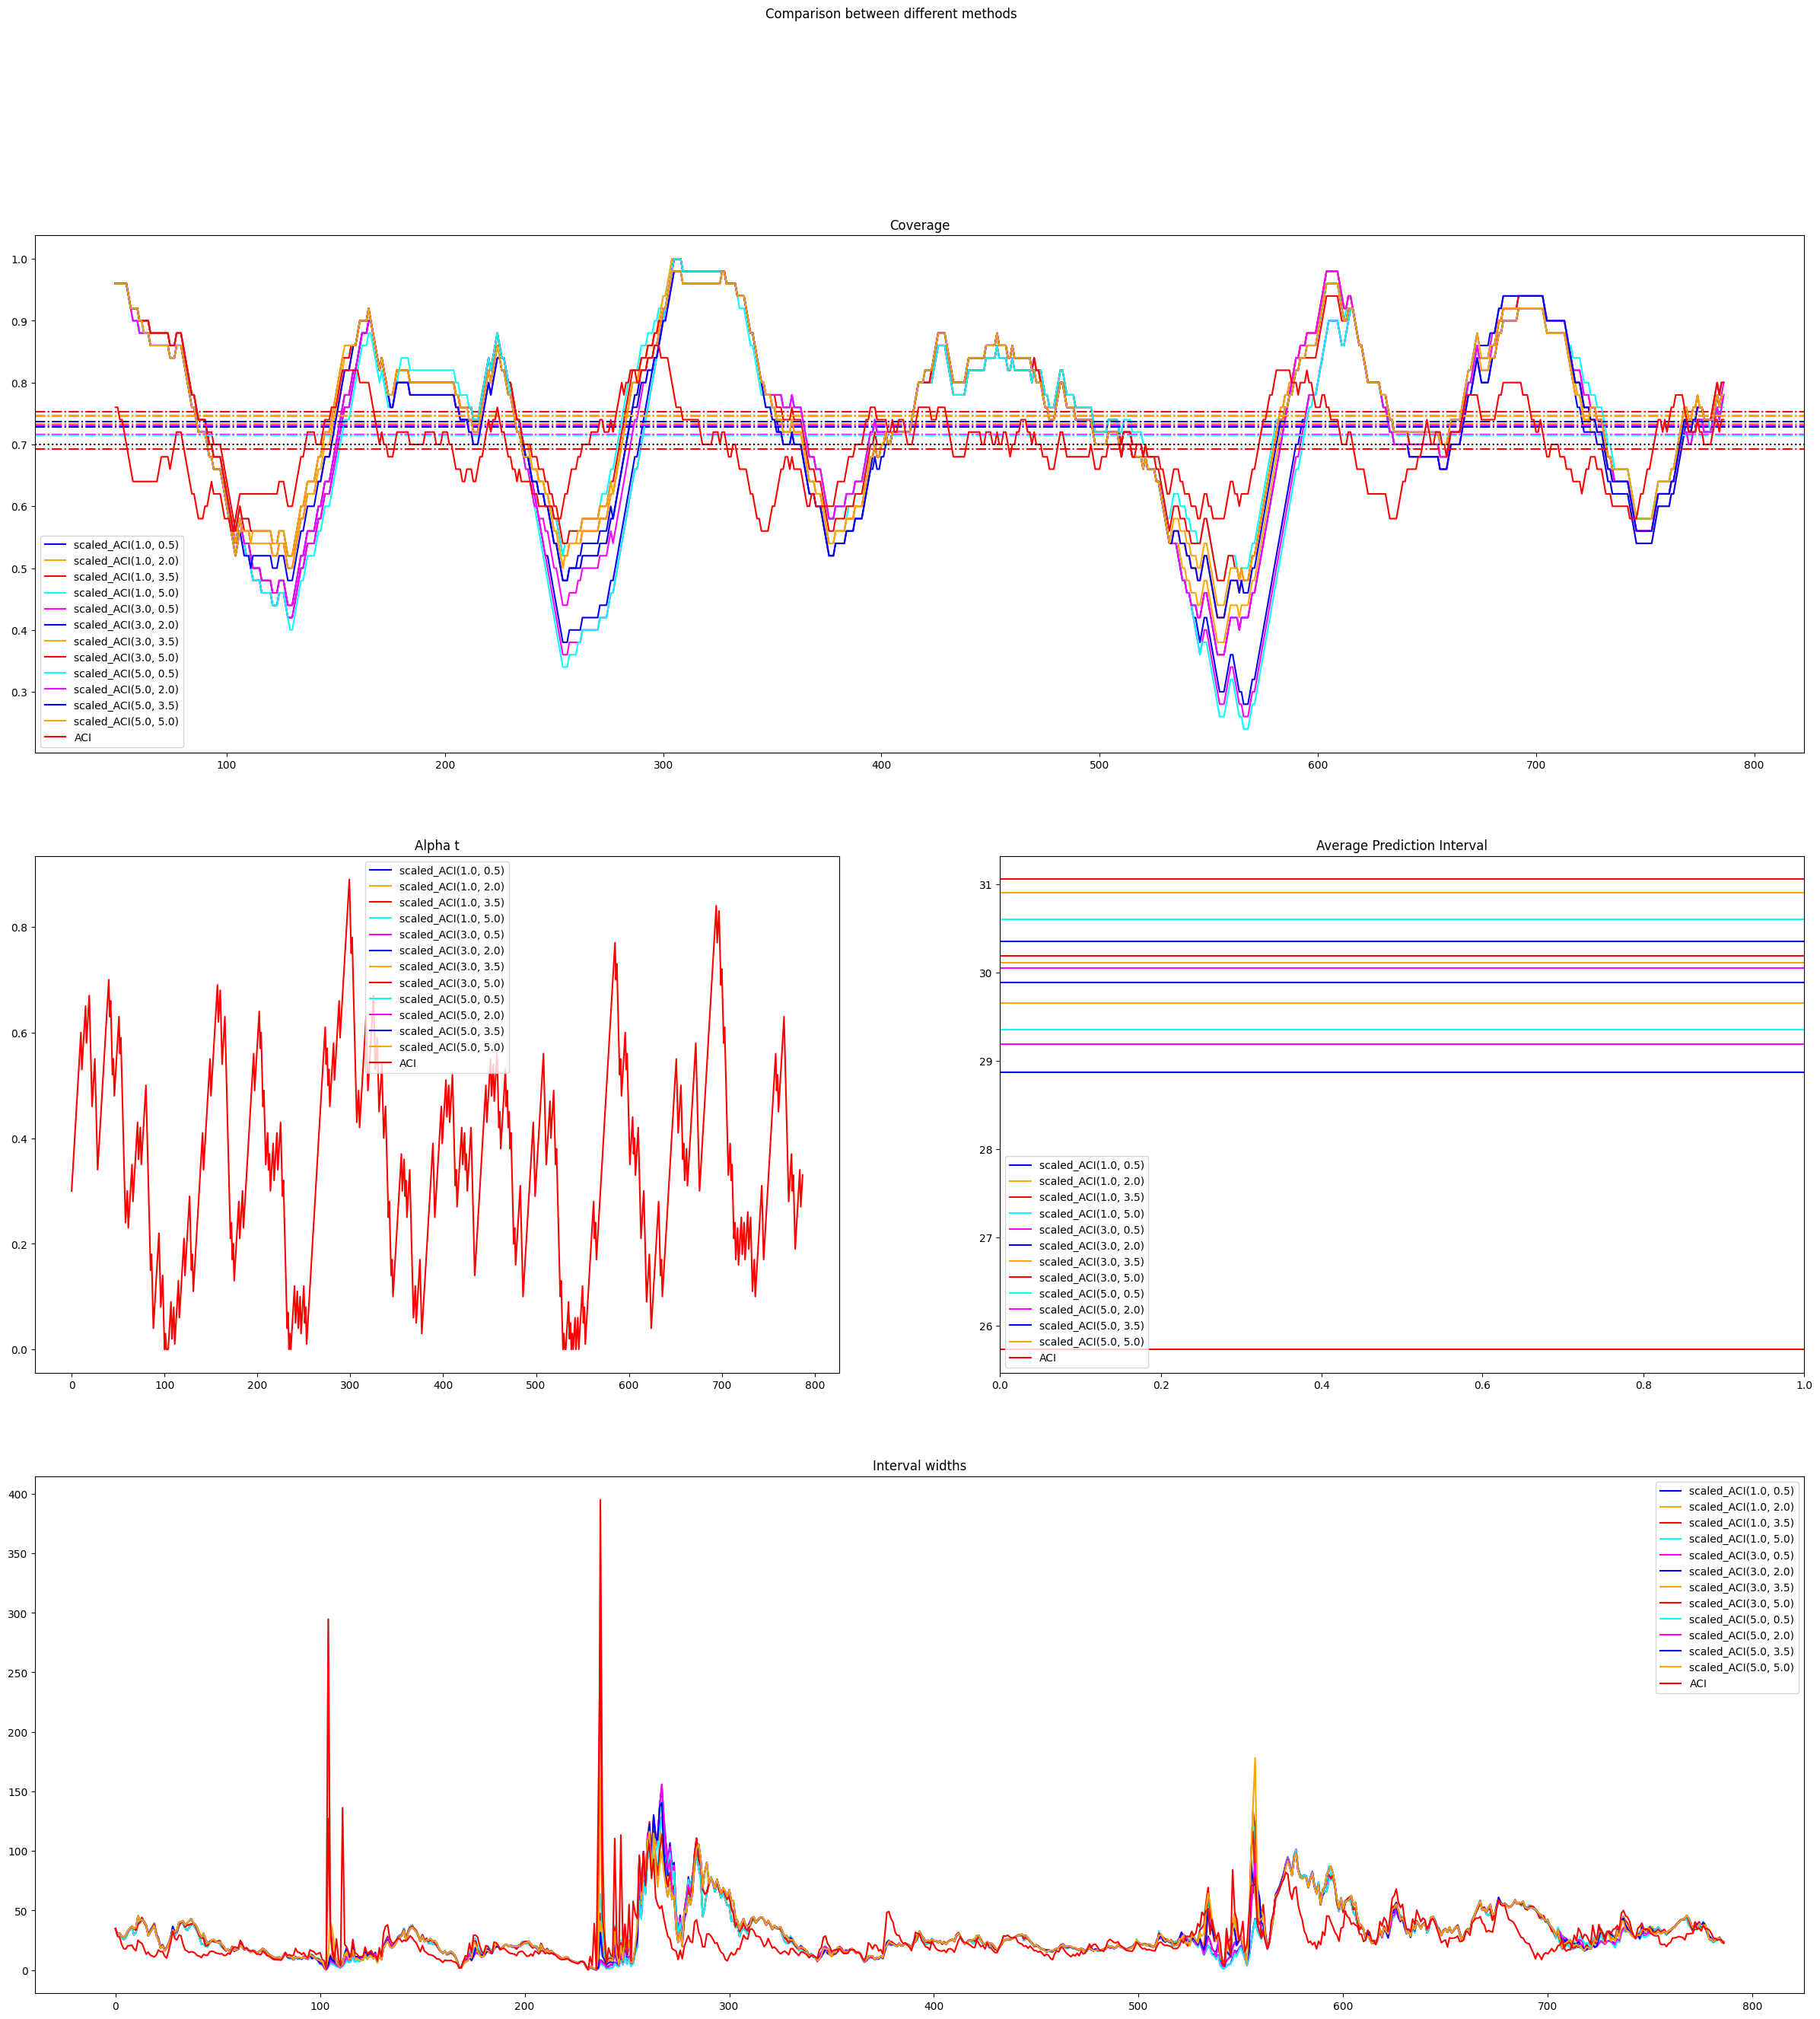

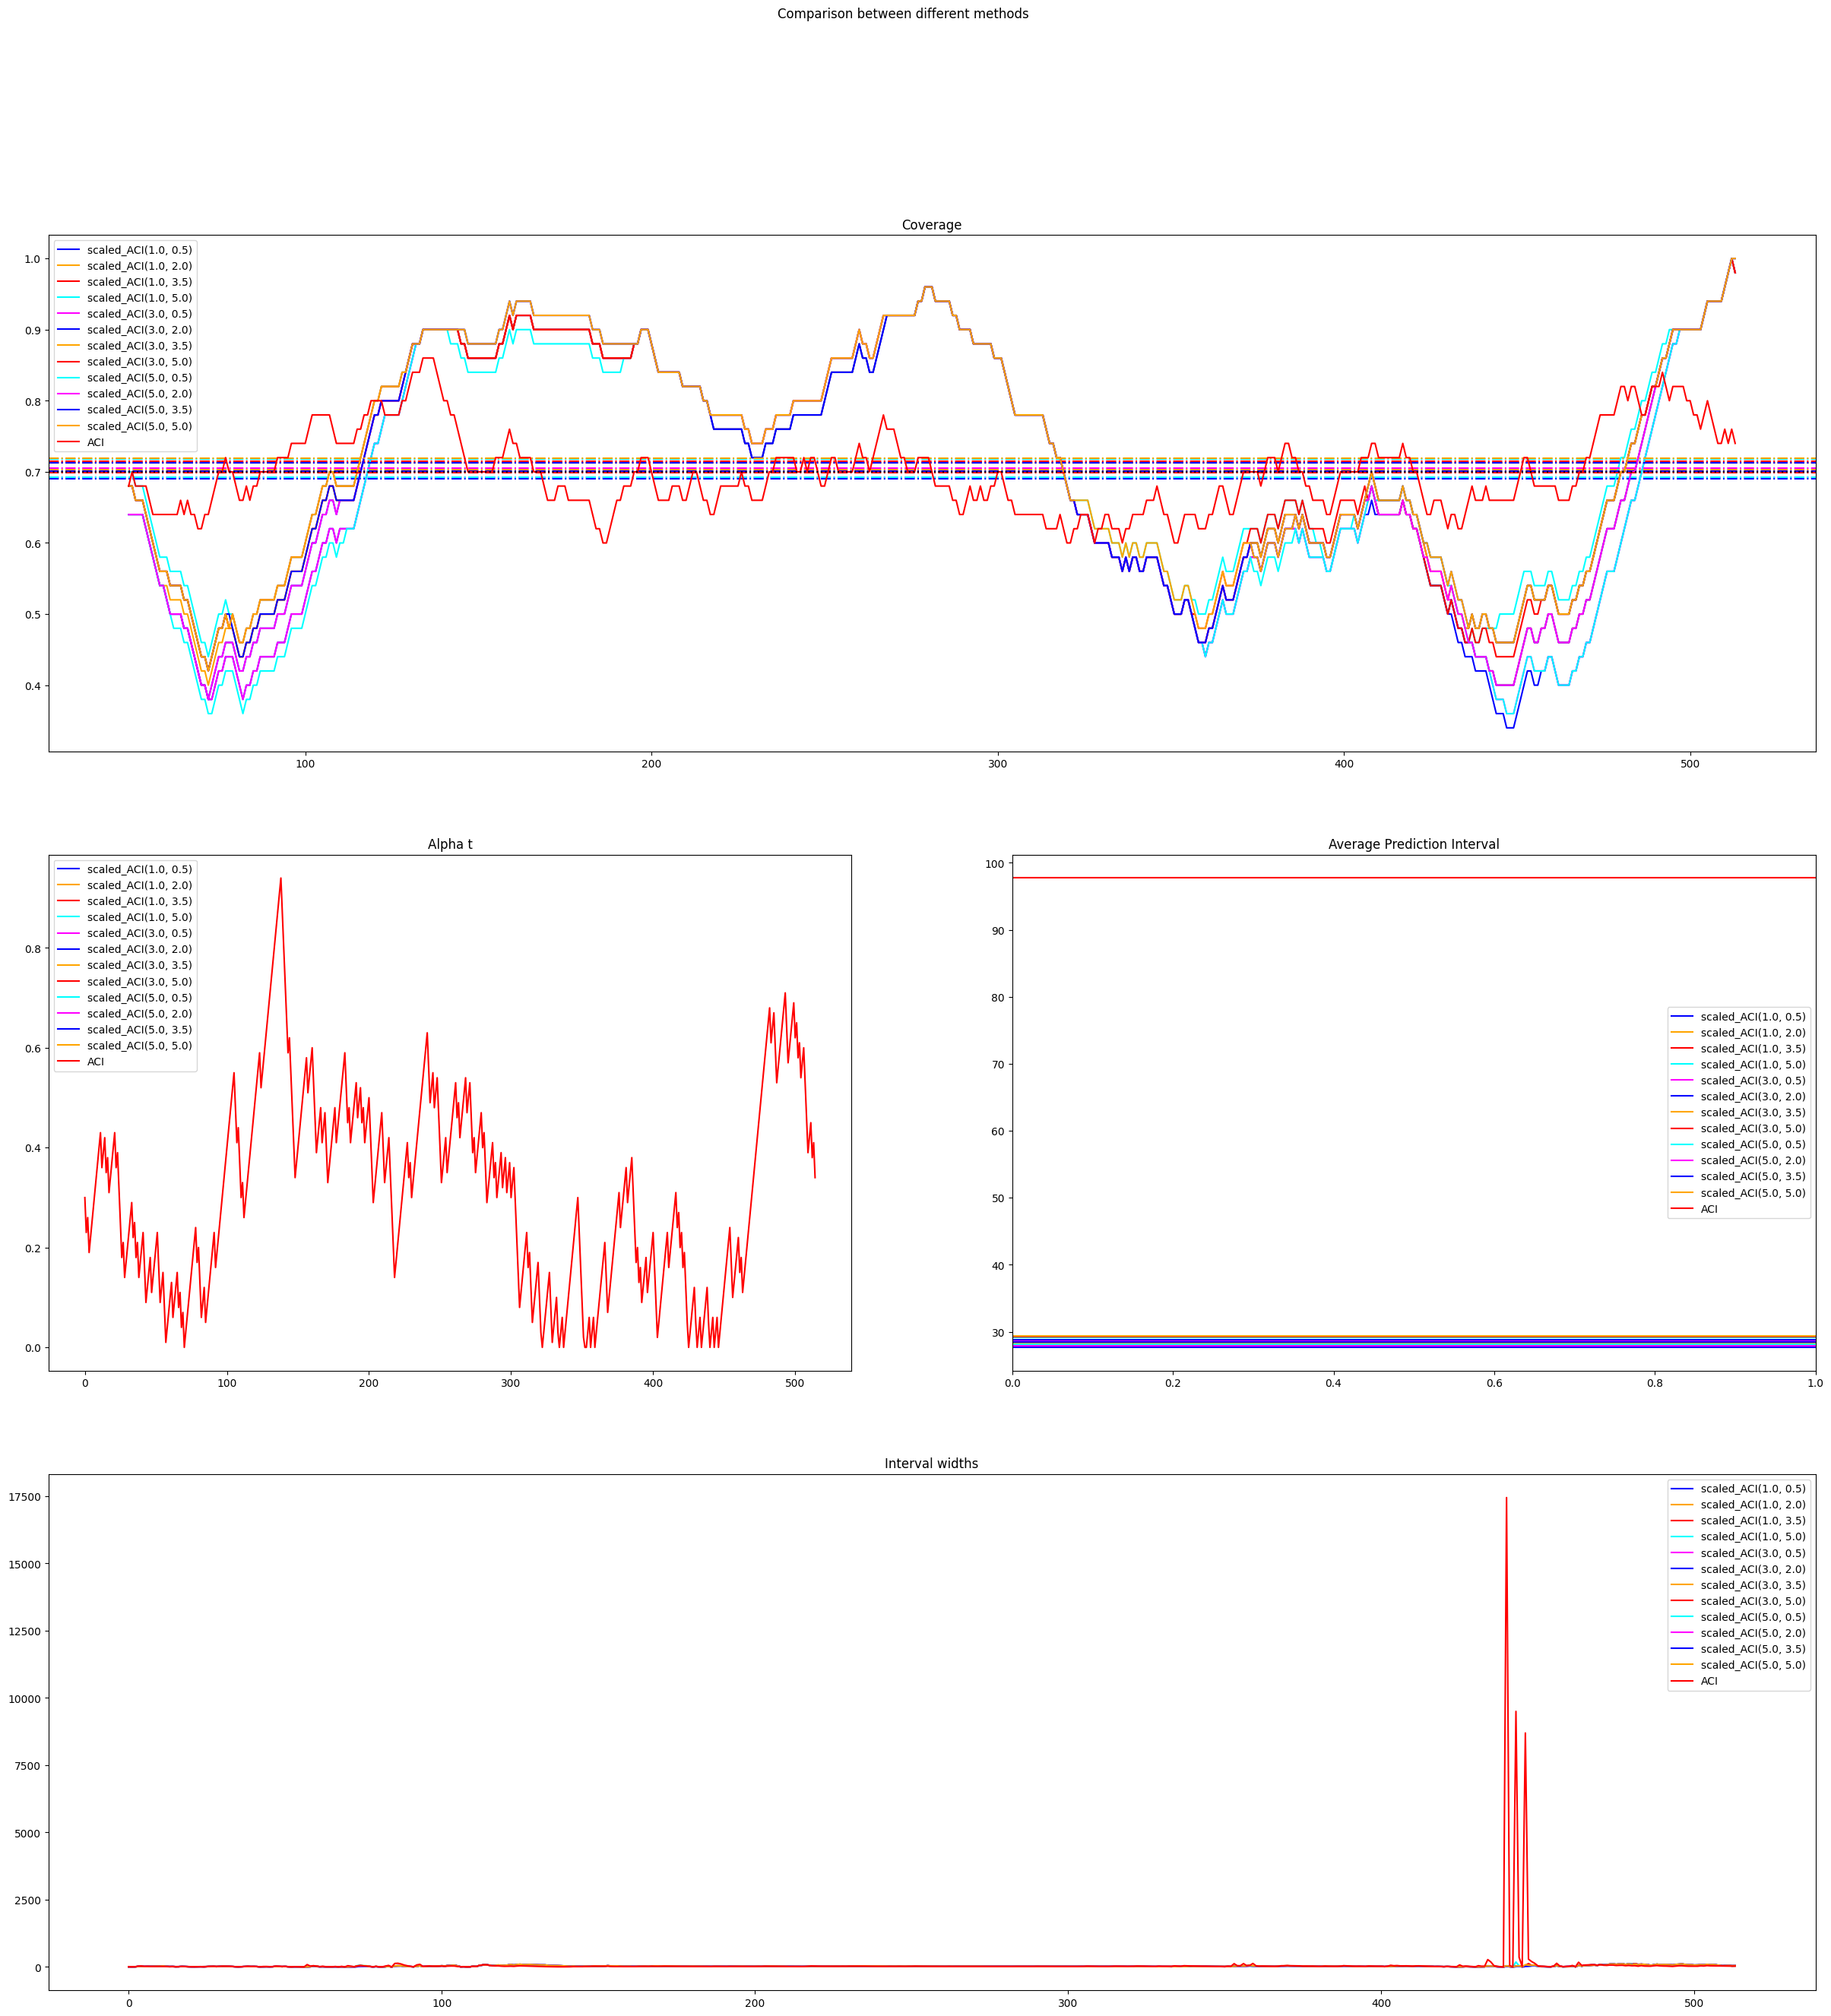

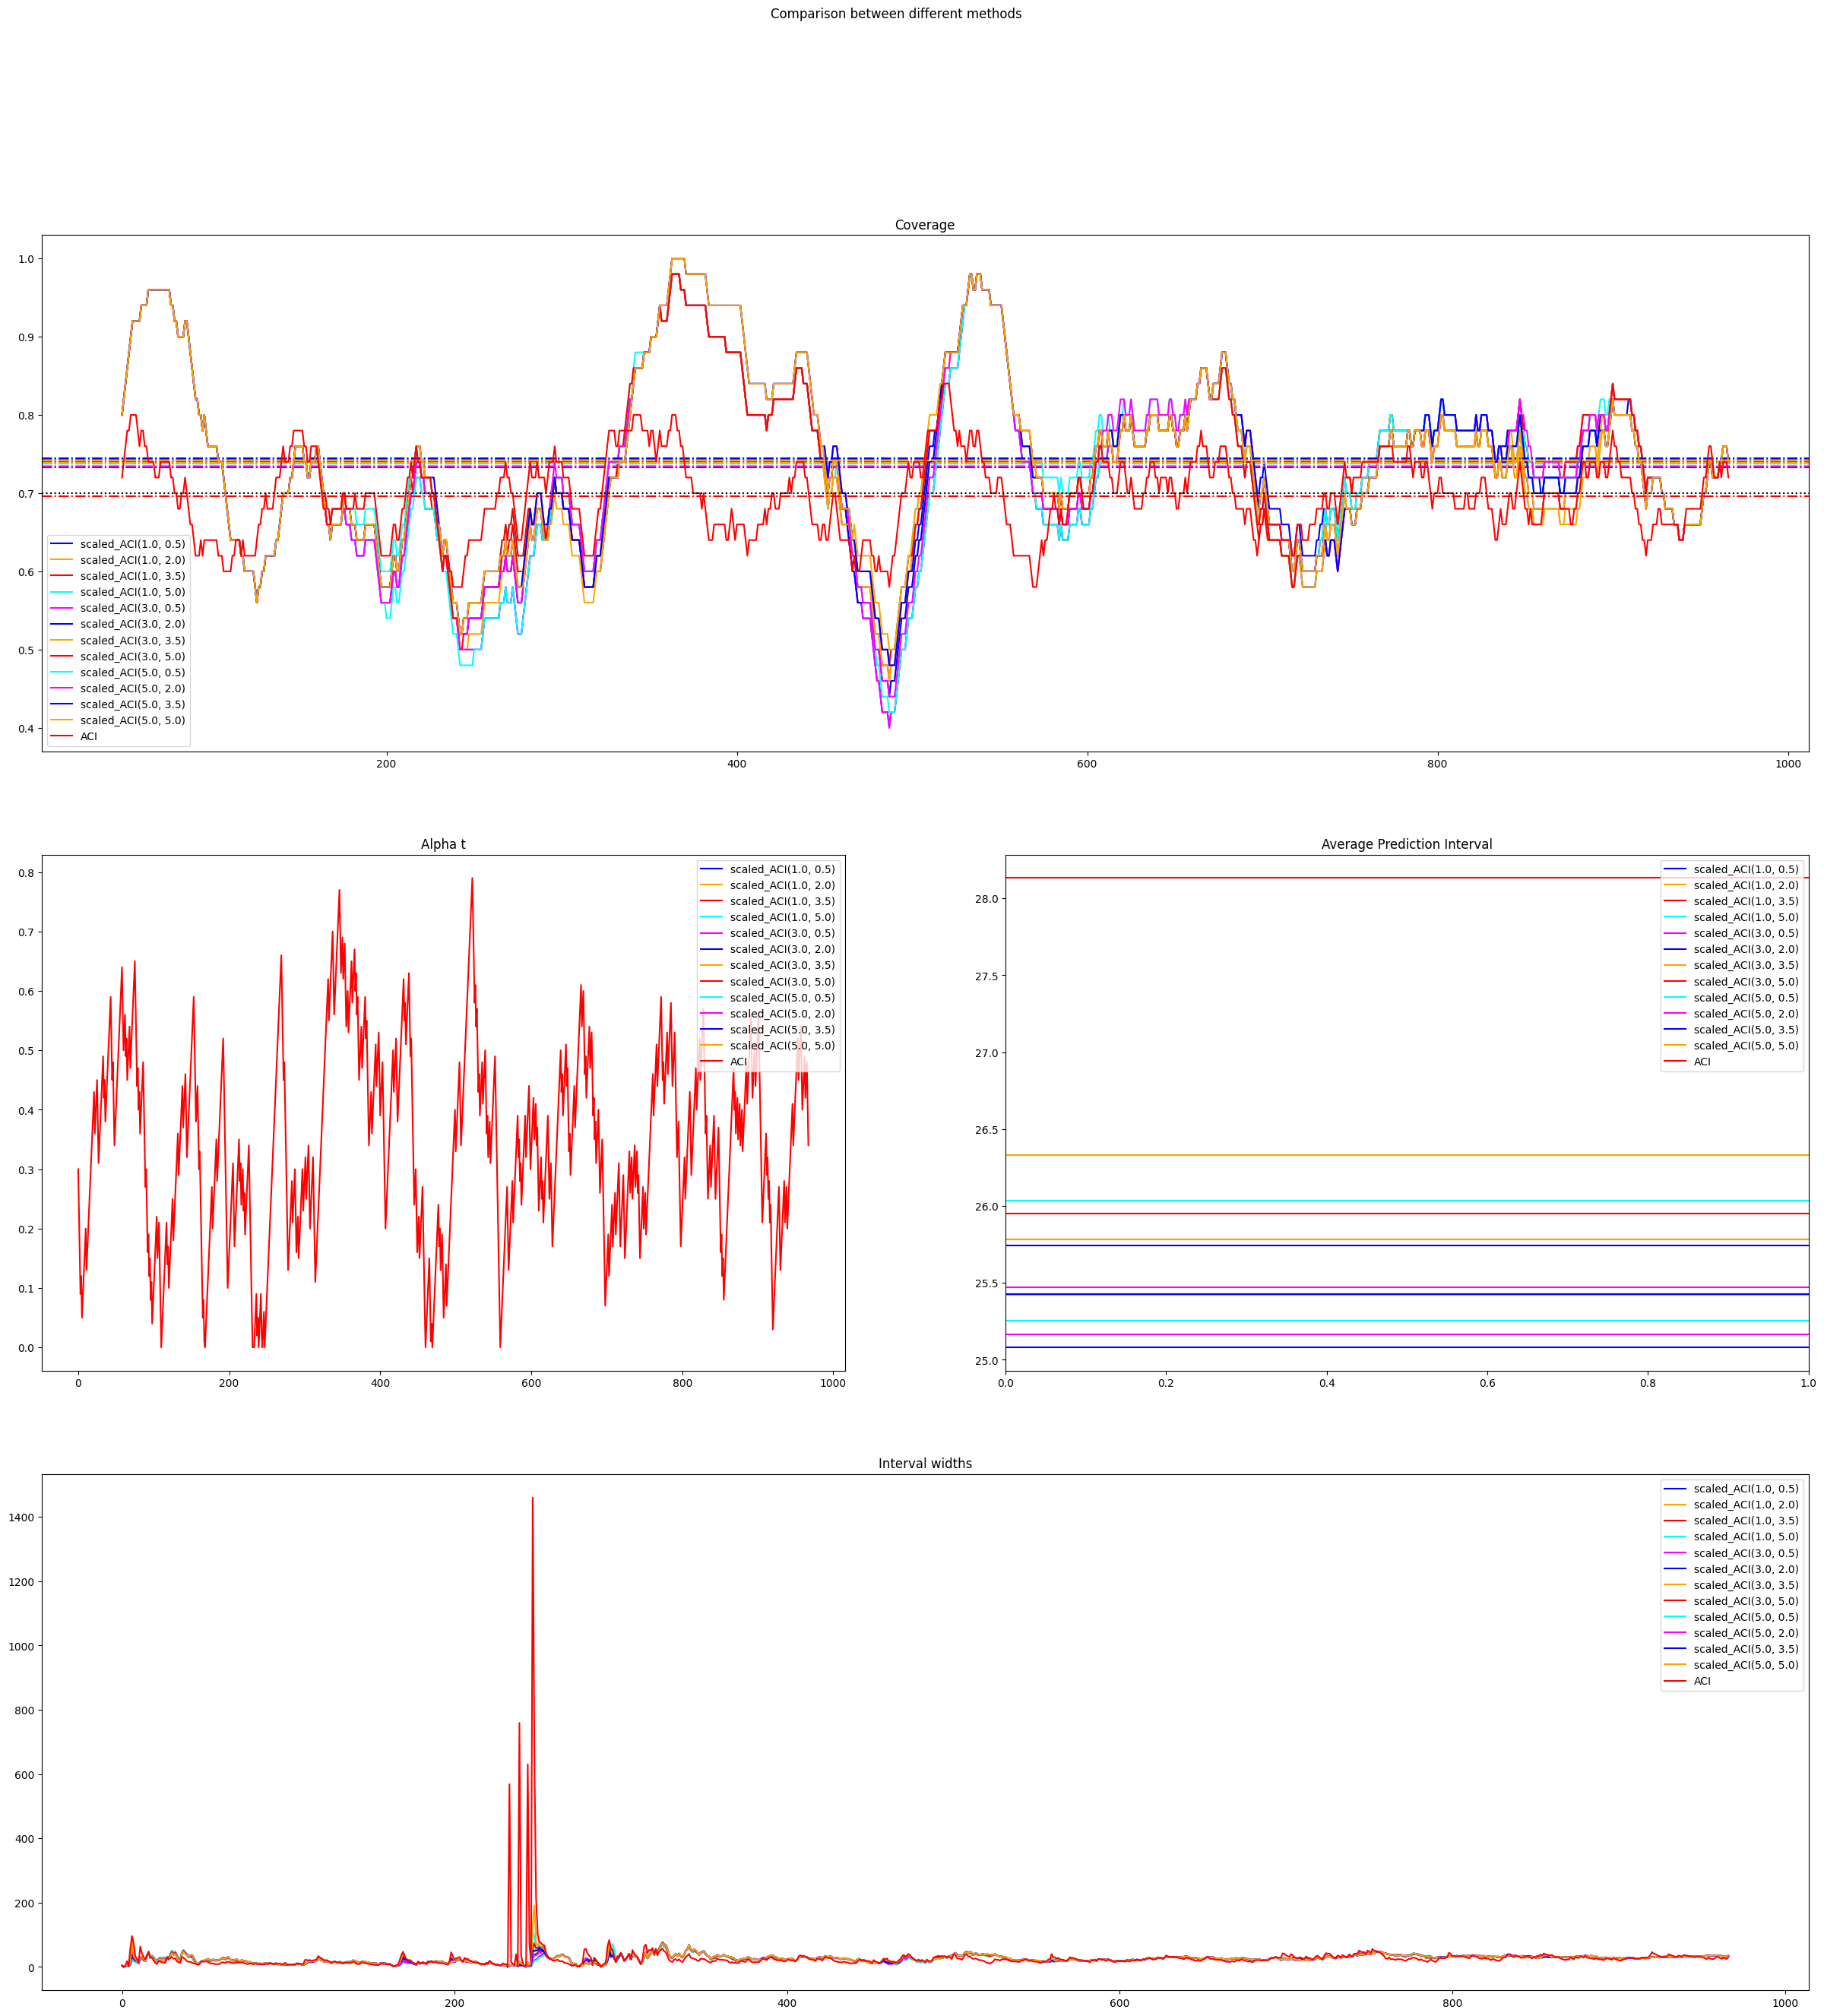

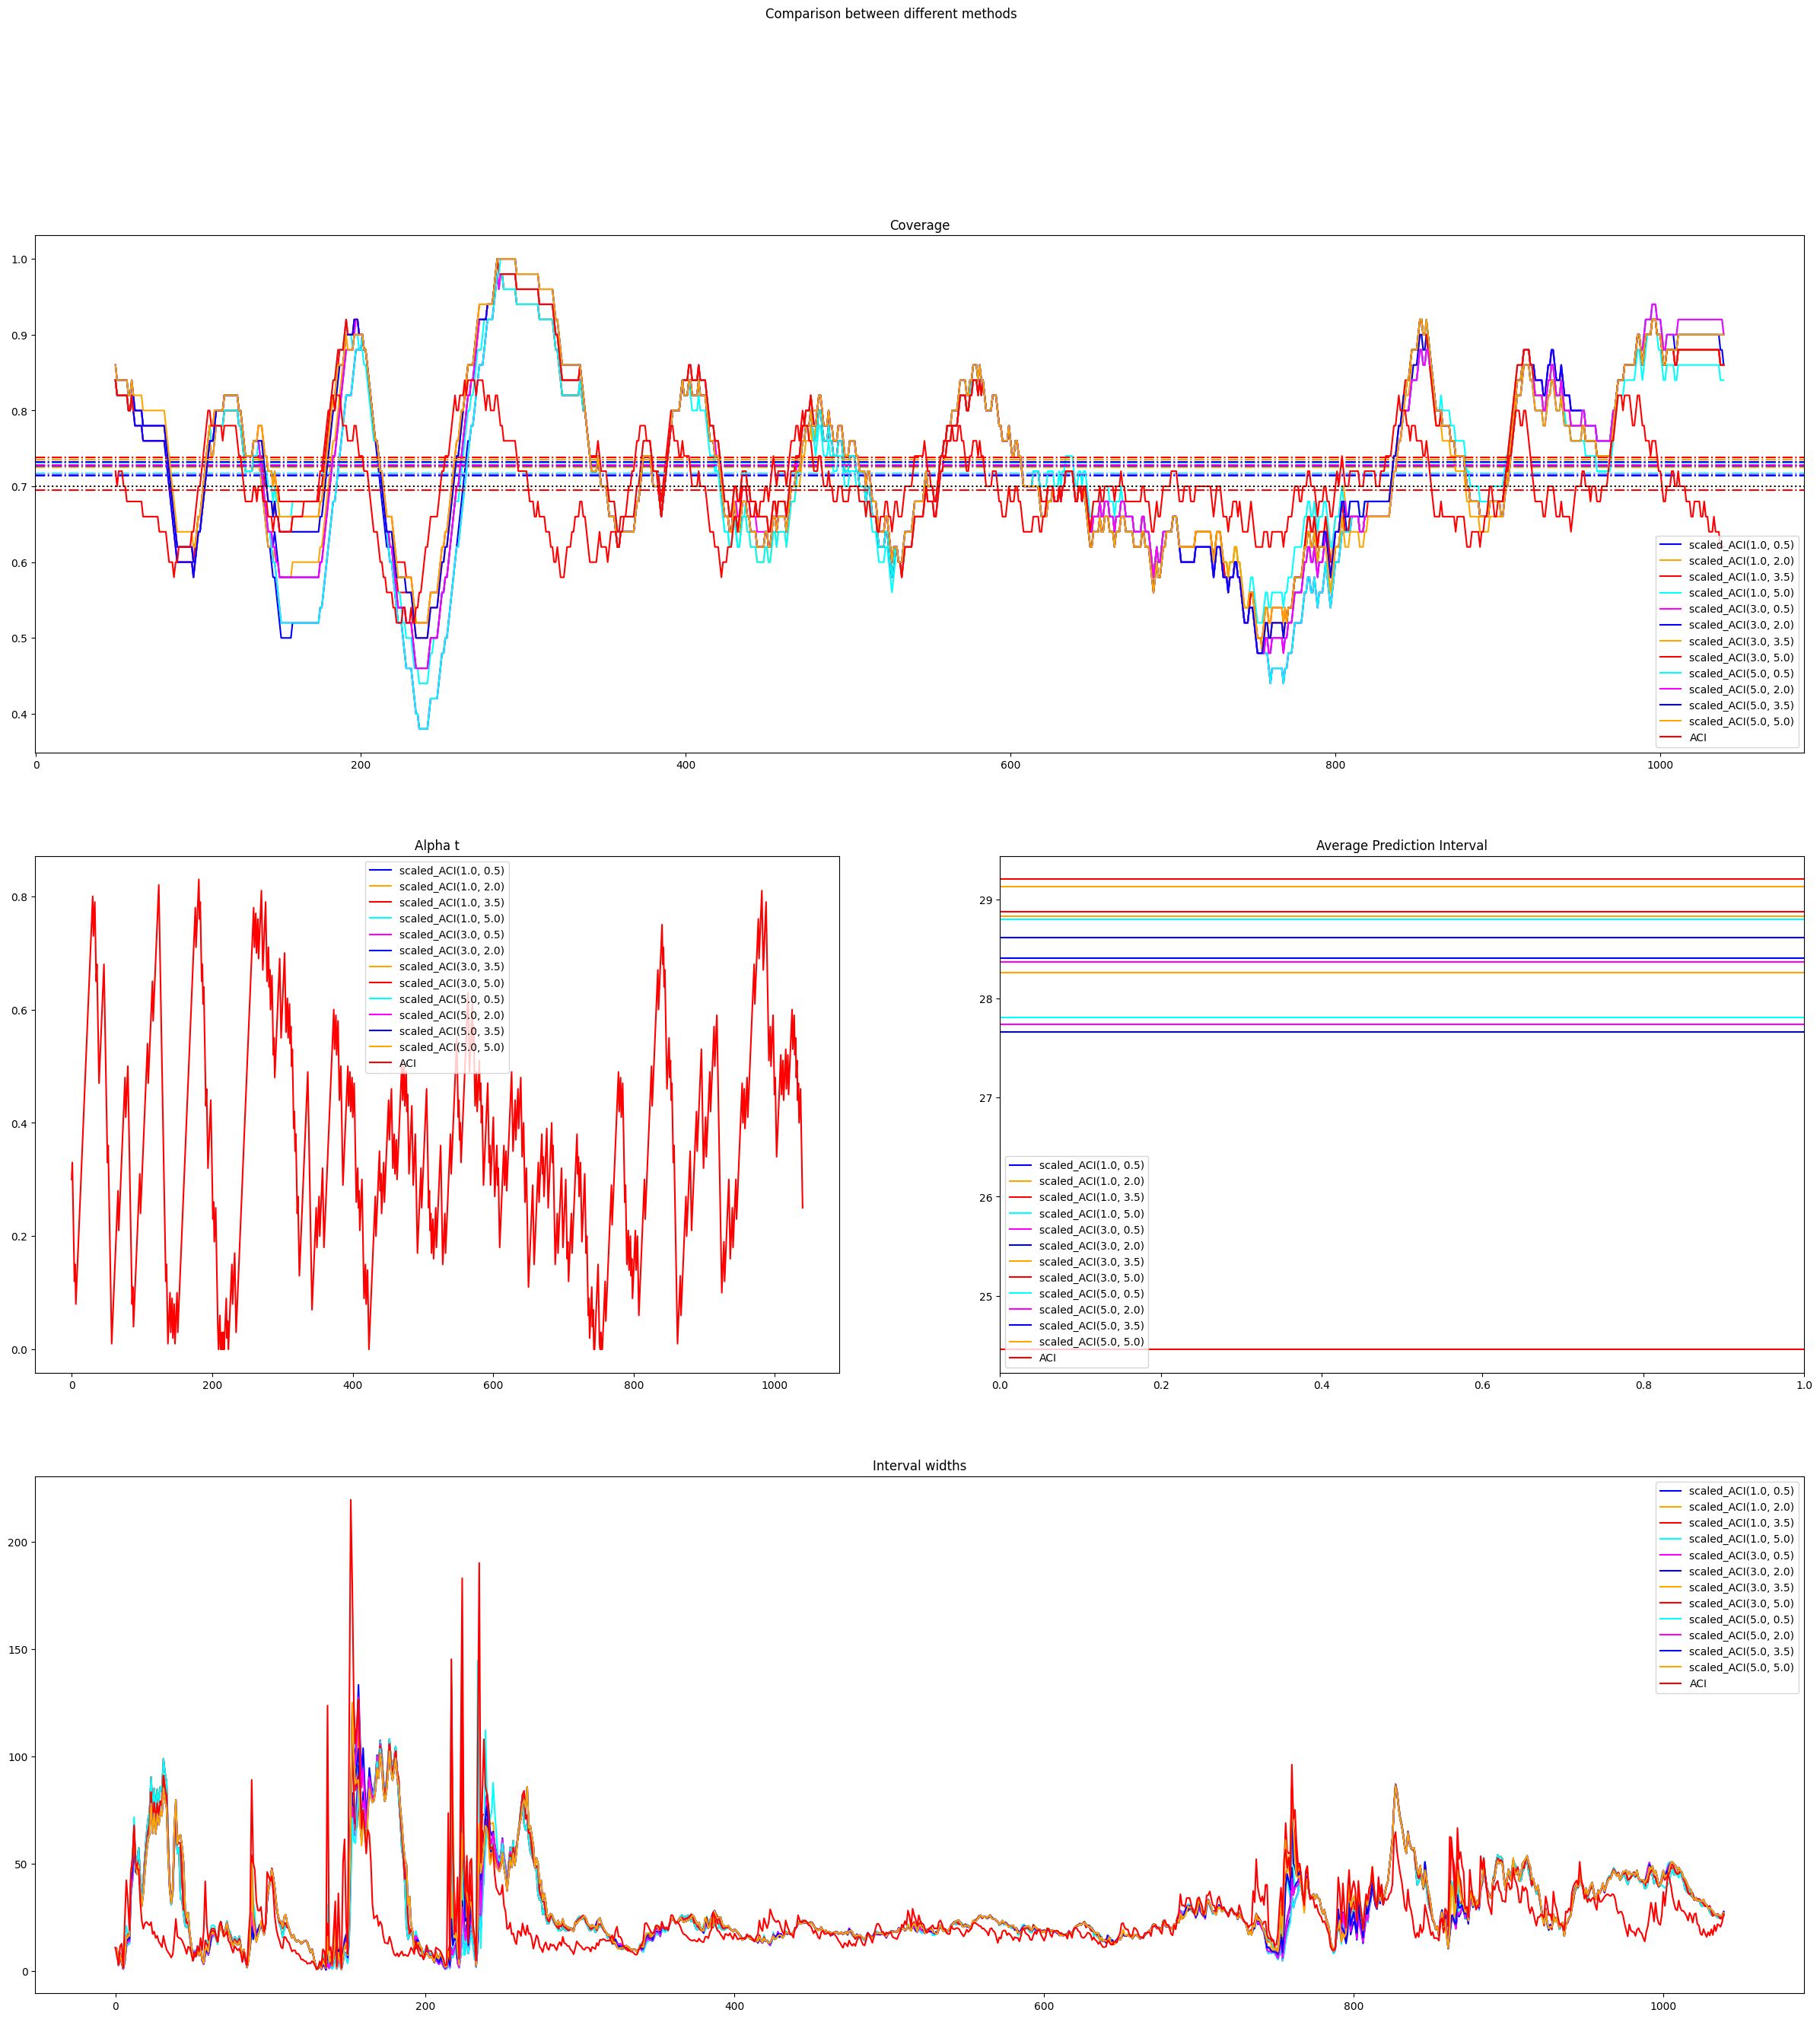

KeyboardInterrupt: 

In [111]:
# This attempts to plot a range of parameters.

from ConformalMethods import ACP_plots
from ConformalMethods import AdaptiveCP
import itertools

ACP = AdaptiveCP(0.3)

records = [[], []]
coverage_records = [[], []]

paramtext = list(itertools.product(np.linspace(1, 5, 3).tolist(), np.linspace(0.5, 5, 4).tolist()))
print(paramtext)


for i, data in enumerate(all_data):
    all_param_lookback = []
    
    for param in paramtext:
        plook = parameter_lookback(0.3, data, param[0], param[1], 50)
        plook['model'] = plook['model'] + str(param)
        all_param_lookback.append(plook)

    Aci = ACP.ACI(data, 0.1)


    # records[0].append(scaled['average_prediction_interval'])
    # records[1].append(non_adaptive['average_prediction_interval'])
    # coverage_records[0].append(scaled['realised_interval_coverage'])
    # coverage_records[1].append(non_adaptive['realised_interval_coverage'])

    # print('Widths: my method', np.mean(records[0]), 'ACI', np.mean(records[1]))
    # print('Coverage:my method', np.mean(coverage_records[0]), 'ACI', np.mean(coverage_records[1]))
    # print('Covearge Variance: my method', np.var(scaled['error_t_list']) , 'ACI', np.var(np.array(non_adaptive['error_t_list'])))
    all_param_lookback.append(Aci)
    if i <5:
        ACP_plots.compare_many(all_param_lookback, figsize=(30,30))

We observe that this performs better than non adaptive when is good when the data is getting larger and larger, but the current implementation cant deal with when over covering.

In [ ]:
from ConformalMethods import ACP_data
second_dataloader = ACP_data(100, 600, dist_shifts=[(30, 30), (20, 20), (10, 10), (0, 5)])
second_data = second_dataloader.generate()

In [ ]:
# av = []
# for i, data in enumerate(second_data):
#     dt = ACP.DtACI(data)
#     av.append(dt['average_prediction_interval'])
#     print('dt', np.mean(av))

In [ ]:
from ConformalMethods import ACP_data
dataloader = ACP_data(5, 600)
all_data = dataloader.generate()

In [ ]:
records2 = [[], []]
for i, data in enumerate(second_data):
    plook = scaled_ACI(0.3, data, 0.1, 50)
    non_adaptive = ACP.ACI(data, 0.1)
    records2[0].append(plook['average_prediction_interval'])
    records2[1].append(non_adaptive['average_prediction_interval'])
    print('scaled', np.mean(records2[0]), 'ACI', np.mean(records2[1]))
    
    

scaled 64.55953381418294 ACI 50.275027331136734
scaled 65.42403186978021 ACI 58.633342833570325
scaled 69.6734305573388 ACI 57.67366143733707
scaled 79.60782017532819 ACI 61.46031378426841
scaled 83.14155783847423 ACI 62.388015997148116
scaled 81.24048925541875 ACI 66.19090606894825
scaled 81.38355506836221 ACI 70.55061442033666
scaled 81.9962439977253 ACI 69.8095181245658
scaled 80.36311245879541 ACI 68.59612624790928
scaled 83.55625755336128 ACI 67.64531850397701
scaled 85.99305016518002 ACI 67.80485358746635
scaled 86.75018338861122 ACI 71.57865347978488
scaled 85.9951268327398 ACI 70.67798694779125
scaled 85.00937307268984 ACI 70.30735224210436
scaled 86.5483614280872 ACI 71.76496074820251
scaled 85.25390974991956 ACI 70.91747850226969
scaled 86.94772525040392 ACI 71.58706260295781
scaled 86.53533692668556 ACI 70.94270870979473
scaled 87.2153409026357 ACI 71.87862539241051
scaled 87.3351189013513 ACI 72.76651615917021
scaled 87.34553412909233 ACI 73.8294288008784
scaled 86.51210086

It does seem to be performing worse. On the data which is getting smaller. It is occasionaly well below suggesting that it is more robust.